In [1]:
import os
from pprint import pprint
import sys
import pickle

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy import stats
from scipy.signal import find_peaks, hilbert

project_root = '..'
sys.path.append(project_root)

from sleeprnn.common import viz, constants
from sleeprnn.helpers import reader, plotter, misc, performer
from sleeprnn.detection import metrics
from figs_thesis import fig_utils
from baselines_scripts.butils import get_partitions
from sleeprnn.detection.feeder_dataset import FeederDataset
from sklearn.linear_model import LinearRegression, HuberRegressor
from sleeprnn.data import utils

RESULTS_PATH = os.path.join(project_root, 'results')
BASELINES_PATH = os.path.join(project_root, 'resources', 'comparison_data', 'baselines_2021')

%matplotlib inline
viz.notebook_full_width()

param_filtering_fn = fig_utils.get_filtered_signal_for_event
param_frequency_fn = fig_utils.get_frequency_by_fft
param_amplitude_fn = fig_utils.get_amplitude_event

# SpindleU-net

In [41]:
def cv_split(n_folds, fold_id, seed, subject_ids):
        """k-fold CV splits, by-subject split.
        Inputs:
            n_folds: number of folds of CV
            fold_id: integer in [0, 1, ..., n_folds - 1] (which fold to retrieve)
            seed: random seed (determines the permutation of subjects to generate k-fold CV)
            subject_ids: optional list of subject to restrict the cv. By default uses all ids.
        Returns 3 lists of IDs: train_ids, val_ids, test_ids.
        """
        if fold_id >= n_folds:
            raise ValueError("fold id %s invalid for %d folds" % (fold_id, n_folds))
        n_test = int(np.ceil(len(subject_ids) / n_folds))
        attempts = 1
        while True:
            # Random permutation
            subject_ids_1 = np.random.RandomState(seed=seed).permutation(subject_ids)
            subject_ids_2 = np.random.RandomState(seed=seed + attempts).permutation(subject_ids)
            subject_ids_extended = np.concatenate([subject_ids_1, subject_ids_2])
            # Form folds
            test_folds = []
            for i in range(n_folds):
                start_loc = i * n_test
                end_loc = (i + 1) * n_test
                subset_of_subjects = subject_ids_extended[start_loc:end_loc]
                subset_of_subjects = np.unique(subset_of_subjects)
                test_folds.append(subset_of_subjects)
            # Test two breaking conditions to avoid problems when extending the list
            # Test length condition
            concat_folds = np.concatenate(test_folds)
            cond1 = (concat_folds.size == (n_test * n_folds))
            # val sets and test sets do not overlap
            val_folds = [test_folds[(loc + 1) % n_folds] for loc in range(n_folds)]
            concat_test_and_val = [np.concatenate([v, t]) for v, t in zip(val_folds, test_folds)]
            concat_test_and_val = [np.unique(a) for a in concat_test_and_val]
            concat_test_and_val = np.concatenate(concat_test_and_val)
            cond2 = (concat_test_and_val.size == (2 * n_test * n_folds))
            if cond1 and cond2:
                break
            else:
                attempts = attempts + 1000
        # Select split
        test_ids = test_folds[fold_id]
        val_ids = test_folds[(fold_id + 1) % n_folds]
        train_ids = [s for s in subject_ids if s not in np.concatenate([val_ids, test_ids])]
        # Sort
        train_ids = np.sort(train_ids).tolist()
        val_ids = np.sort(val_ids).tolist()
        test_ids = np.sort(test_ids).tolist()
        return train_ids, val_ids, test_ids

In [2]:
bysubject_metrics_e1 = {
    'subject_id': np.arange(1, 20).astype(np.int32),
    'precision': [
        893, 885, 748, 726, 829, 825, 772, 779, 890, 825,
        610, 762, 763, 700, 791, 679, 864, 837, 801
    ],
    'recall': [
        834, 787, 838, 775, 701, 693, 814, 863, 845, 902,
        957, 894, 898, 958, 701, 920, 736, 855, 806
    ],
    'f1score': [
        862, 833, 791, 750, 760, 754, 793, 819, 867, 862,
        745, 823, 825, 809, 743, 781, 795, 846, 803
    ],
}

bysubject_metrics_e2 = {
    'subject_id': np.arange(1, 16).astype(np.int32),
    'precision': [
        941, 940, 977, 933, 959, 884, 928, 947, 867, 790, 795, 728, 800, 816, 661
    ],
    'recall': [
        870, 783, 775, 769, 595, 829, 856, 884, 940, 932, 935, 953, 914, 929, 960
    ],
    'f1score': [
        904, 854, 865, 843, 734, 856, 891, 914, 902, 855, 859, 825, 853, 869, 783
    ],
}
bysubject_metrics_e1 = pd.DataFrame.from_dict(bysubject_metrics_e1)
bysubject_metrics_e2 = pd.DataFrame.from_dict(bysubject_metrics_e2)

# bysubject_metrics_e1 = bysubject_metrics_e1[bysubject_metrics_e1.subject_id != 15] # drop the worst subject to estimate standard deviation with simplicity

In [3]:
def get_fold_metrics(df):
    subject_ids = df.subject_id.values
    fold_size = 3
    n_seeds = 3

    n_folds = len(subject_ids) // fold_size
    test_ids_list = []
    for cv_seed in range(n_seeds):
        for fold_id in range(n_folds):
            _, _, test_ids = cv_split(n_folds, fold_id, cv_seed, subject_ids)
            test_ids_list.append(test_ids)

    fold_metrics = {'f1score': [], 'recall': [], 'precision': []}
    for fold_id in range(len(test_ids_list)):
        fold_subjects = test_ids_list[fold_id]
        fold_data = df[np.isin(df.subject_id, fold_subjects)].mean() / 10.0
        for key in fold_metrics.keys():
            fold_metrics[key].append(fold_data[key])
    fold_metrics = pd.DataFrame.from_dict(fold_metrics)
    return fold_metrics


fold_metrics_e1 = get_fold_metrics(bysubject_metrics_e1)
fold_metrics_e2 = get_fold_metrics(bysubject_metrics_e2)

print("\nE1")
print(fold_metrics_e1.mean())
print(fold_metrics_e1.std(ddof=0))

print("\nE2")
print(fold_metrics_e2.mean())
print(fold_metrics_e2.std(ddof=0))

NameError: name 'cv_split' is not defined

In [11]:
# for mass 10
# partition strategy (custom):
start_seed = 0
n_subjects = 19
width = 5
sequence_of_locs = []
for i in range(4):
    start_seed += 1
    is_invalid = True
    while is_invalid:
        indices = np.random.RandomState(seed=start_seed).permutation(n_subjects)
        last_subjects = sequence_of_locs[-width:]
        first_subjects = indices[:width]
        window_subjects = np.concatenate([first_subjects, last_subjects])
        n_window = len(np.unique(window_subjects))
        if n_window == len(window_subjects):
            is_invalid = False
        start_seed += 1
    sequence_of_locs.extend(indices)

# Populate test sets
test_ids_list = []
all_ids = np.arange(1, 20).astype(np.int32)
sequence_of_locs = np.reshape(sequence_of_locs, (-1, 4))
for fold_id in range(19):
    test_locs = sequence_of_locs[fold_id]
    test_ids = [all_ids[loc] for loc in test_locs]
    test_ids.sort()
    test_ids_list.append(test_ids)
    
# Compute performance
df = bysubject_metrics_e1
fold_metrics = {'f1score': [], 'recall': [], 'precision': []}
for fold_id in range(len(test_ids_list)):
    fold_subjects = test_ids_list[fold_id]
    fold_data = df[np.isin(df.subject_id, fold_subjects)]
    fold_data = fold_data.mean() / 10.0
    for key in fold_metrics.keys():
        fold_metrics[key].append(fold_data[key])
fold_metrics = pd.DataFrame.from_dict(fold_metrics)
# fold_metrics

# by_subject_dispersion of mass19 with 19 folds and fold size 4
print("\nE1")
print(fold_metrics.mean())
print(fold_metrics.std(ddof=0))


E1
f1score      80.321053
recall       83.036842
precision    78.836842
dtype: float64
f1score      2.311929
recall       3.312689
precision    3.381951
dtype: float64


# Comparación E1 y E2 en MASS-SS2

In [ ]:
def get_marks(dataset_name, expert):
    dataset = reader.load_dataset(dataset_name, verbose=False)
    marks_list = dataset.get_stamps(pages_subset=constants.N2_RECORD, which_expert=expert)
    return marks_list


events_list = get_marks(constants.MASS_SS_NAME, 1)
detections_list = get_marks(constants.MASS_SS_NAME, 2)
performance = fig_utils.compute_fold_performance(events_list, detections_list, constants.MACRO_AVERAGE)
for metric_name in performance.keys():
    print('%s: %1.1f%%' % (metric_name.ljust(10), 100 * performance[metric_name]))

# Tabla de desempeño (by-fold)
Comparación con la literatura en desempeño in-dataset.
Todos los P-value de REDv2-CWT son mayores a 0.05.
Todos los P-value de baselines son menor a 0.001 excepto en INTA-UCH.

In [ ]:
models = [constants.V2_TIME, constants.V2_CWT1D]
baselines_ss = ['dosed', 'a7']
baselines_kc = ['dosed', 'spinky']
print_model_names = {
    constants.V2_TIME: '\\textbf{REDv2-Time}',
    constants.V2_CWT1D: '\\textbf{REDv2-CWT}',
    'dosed': 'DOSED \cite{chambon2019dosed}',
    'a7': 'A7 \cite{lacourse2019sleep}',
    'spinky': 'Spinky \cite{lajnef2017meet}'
}

eval_configs = [
    dict(dataset_name=constants.MASS_SS_NAME, expert=1, strategy='fixed', seeds=11),
    dict(dataset_name=constants.MASS_SS_NAME, expert=2, strategy='fixed', seeds=11),
    dict(dataset_name=constants.MASS_KC_NAME, expert=1, strategy='fixed', seeds=11),
    dict(dataset_name=constants.MODA_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.INTA_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_SS_NAME, expert=2, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_KC_NAME, expert=1, strategy='5cv', seeds=3),
]
for config in eval_configs:
    print("\nLoading", config)
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    baselines = baselines_ss if dataset.event_name == constants.SPINDLE else baselines_kc
    
    # Collect predictions
    pred_dict = {}
    for model_version in models:
        tmp_dict = fig_utils.get_red_predictions(model_version, config["strategy"], dataset, config["expert"], verbose=False)
        # Retrieve only predictions, same format as baselines
        pred_dict[model_version] = {}
        for k in tmp_dict.keys():
            fold_subjects = tmp_dict[k][constants.TEST_SUBSET].all_ids
            fold_predictions = tmp_dict[k][constants.TEST_SUBSET].get_stamps()
            pred_dict[model_version][k] = {s: pred for s, pred in zip(fold_subjects, fold_predictions)}
    for baseline_name in baselines:
        pred_dict[baseline_name] = fig_utils.get_baseline_predictions(baseline_name, config["strategy"], config["dataset_name"], config["expert"])
    # print("Loaded models:", pred_dict.keys())
    
    # Measure performance byfold
    average_mode = constants.MICRO_AVERAGE if (config["dataset_name"] == constants.MODA_SS_NAME) else constants.MACRO_AVERAGE
    _, _, test_ids_list = get_partitions(dataset, config["strategy"], config["seeds"])
    n_folds = len(test_ids_list)
    table = {'Detector': [], 'F1-score': [], 'Recall': [], 'Precision': [], 'mIoU': [], 'Fold': []}
    for model_name in pred_dict.keys():
        for k in range(n_folds):
            subject_ids = test_ids_list[k]
            feed_d = FeederDataset(dataset, subject_ids, constants.N2_RECORD, which_expert=config["expert"])
            events_list = feed_d.get_stamps()
            detections_list = [pred_dict[model_name][k][subject_id] for subject_id in subject_ids]
            performance = fig_utils.compute_fold_performance(events_list, detections_list, average_mode)
            table['Detector'].append(model_name)
            table['F1-score'].append(performance['F1-score'])
            table['Recall'].append(performance['Recall'])
            table['Precision'].append(performance['Precision'])
            table['mIoU'].append(performance['mIoU'])
            table['Fold'].append(k)
    table = pd.DataFrame.from_dict(table)
    print("By-fold statistics")
    metric_mean = table.groupby(by=["Detector"]).mean().drop(columns=["Fold"])
    metric_std = table.groupby(by=["Detector"]).std(ddof=0).drop(columns=["Fold"])
    print("Detector & F1-score (\%) & Recall (\%) & Precision (\%) & mIoU (\%) \\\\")
    for model_name in pred_dict.keys():
        print("%s & %s & %s & %s & %s \\\\" % (
            print_model_names[model_name].ljust(10),
            fig_utils.format_metric(metric_mean.at[model_name, "F1-score"], metric_std.at[model_name, "F1-score"]),
            fig_utils.format_metric(metric_mean.at[model_name, "Recall"], metric_std.at[model_name, "Recall"]),
            fig_utils.format_metric(metric_mean.at[model_name, "Precision"], metric_std.at[model_name, "Precision"]),
            fig_utils.format_metric(metric_mean.at[model_name, "mIoU"], metric_std.at[model_name, "mIoU"]),
        ))
    # Statistical tests
    reference_model_name = constants.V2_TIME
    print("P-value test against %s" % reference_model_name)
    for model_name in pred_dict.keys():
        model_metrics = table[table["Detector"] == model_name]["F1-score"].values
        reference_metrics = table[table["Detector"] == reference_model_name]["F1-score"].values
        pvalue = stats.ttest_ind(model_metrics, reference_metrics, equal_var=False)[1]
        print("%s: P %1.4f" % (print_model_names[model_name].ljust(10), pvalue))

# Dispersion by-subject
5CV solamente por brevedad, ya que ya se vio que es similar el desempeño y permite tener todos los sujetos en MASS-SS2.

Datos cuantitativos de dispersión entre sujetos (print esperado):

In [ ]:
models = [constants.V2_TIME, constants.V2_CWT1D]
baselines_ss = ['dosed', 'a7']
baselines_kc = ['dosed', 'spinky']
print_model_names = {
    constants.V2_TIME: 'REDv2-Time',
    constants.V2_CWT1D: 'REDv2-CWT',
    'dosed': 'DOSED',
    'a7': 'A7',
    'spinky': 'Spinky'
}
print_dataset_names = {
    (constants.MASS_SS_NAME, 1): "MASS-SS2-E1SS",
    (constants.MASS_SS_NAME, 2): "MASS-SS2-E2SS",
    (constants.MASS_KC_NAME, 1): "MASS-SS2-KC",
    (constants.MODA_SS_NAME, 1): "MASS-MODA",
    (constants.INTA_SS_NAME, 1): "INTA-UCH",
}

eval_configs = [
    dict(dataset_name=constants.MASS_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_SS_NAME, expert=2, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_KC_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MODA_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.INTA_SS_NAME, expert=1, strategy='5cv', seeds=3),
]
dispersions_list = []
for config in eval_configs:
    print("\nLoading", config)
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    baselines = baselines_ss if dataset.event_name == constants.SPINDLE else baselines_kc
    # Collect predictions
    pred_dict = {}
    for model_version in models:
        tmp_dict = fig_utils.get_red_predictions(model_version, config["strategy"], dataset, config["expert"], verbose=False)
        # Retrieve only predictions, same format as baselines
        pred_dict[model_version] = {}
        for k in tmp_dict.keys():
            fold_subjects = tmp_dict[k][constants.TEST_SUBSET].all_ids
            fold_predictions = tmp_dict[k][constants.TEST_SUBSET].get_stamps()
            pred_dict[model_version][k] = {s: pred for s, pred in zip(fold_subjects, fold_predictions)}
    for baseline_name in baselines:
        pred_dict[baseline_name] = fig_utils.get_baseline_predictions(baseline_name, config["strategy"], config["dataset_name"], config["expert"])
    # Measure performance by subject
    _, _, test_ids_list = get_partitions(dataset, config["strategy"], config["seeds"])
    n_folds = len(test_ids_list)
    table = {'Detector': [], 'F1-score': [], 'Recall': [], 'Precision': [], 'mIoU': [], 'Subject': [], 'Fold': []}
    if config["dataset_name"] == constants.MODA_SS_NAME:
        valid_subjects = [sub_id for sub_id in dataset.all_ids if dataset.data[sub_id]['n_blocks'] == 10 and sub_id not in ['01-01-0012', '01-01-0022']]
        print("moda, using n=", len(valid_subjects))
    else:
        valid_subjects = dataset.all_ids
    for model_name in pred_dict.keys():
        for k in range(n_folds):
            subject_ids = test_ids_list[k]
            feed_d = FeederDataset(dataset, subject_ids, constants.N2_RECORD, which_expert=config["expert"])
            events_list = feed_d.get_stamps()
            detections_list = [pred_dict[model_name][k][subject_id] for subject_id in subject_ids]
            performance = fig_utils.compute_subject_performance(events_list, detections_list)
            for i, subject_id in enumerate(subject_ids):
                if subject_id in valid_subjects:
                    table['Detector'].append(model_name)
                    table['F1-score'].append(performance['F1-score'][i])
                    table['Recall'].append(performance['Recall'][i])
                    table['Precision'].append(performance['Precision'][i])
                    table['mIoU'].append(performance['mIoU'][i])
                    table['Subject'].append(subject_id)
                    table['Fold'].append(k)
    table = pd.DataFrame.from_dict(table)
    bysubject_dispersions = 100 * table.groupby(["Detector", "Subject"]).mean().drop(columns=["Fold"]).groupby("Detector").std(ddof=0)
    dispersions_list.append(bysubject_dispersions)
print("Dispersions computed.")

In [ ]:
for i, config in enumerate(eval_configs):
    print("\nDataset: %s" % print_dataset_names[(config["dataset_name"], config["expert"])])
    print(dispersions_list[i])

In [ ]:
save_figure = True

letters = ['A', 'B', 'C', 'D', 'E', 'F']
fig, axes = plt.subplots(1, 5, figsize=(8, 3), dpi=200, sharex=True)
for i, config in enumerate(eval_configs):
    ax = axes[i]
    disp_table = dispersions_list[i]
    if config["dataset_name"] == constants.MASS_KC_NAME:
        extra_row = pd.DataFrame([["a7", 0, 0, 0, 0]], columns=["Detector", "F1-score", "Recall", "Precision", "mIoU"])
        extra_row = extra_row.set_index("Detector")
        disp_table_mod = disp_table.append(extra_row).reindex(["spinky", "a7", "dosed", constants.V2_CWT1D, constants.V2_TIME])
    else:
        extra_row = pd.DataFrame([["spinky", 0, 0, 0, 0]], columns=["Detector", "F1-score", "Recall", "Precision", "mIoU"])
        extra_row = extra_row.set_index("Detector")
        disp_table_mod = disp_table.append(extra_row).reindex(["spinky", "a7", "dosed", constants.V2_CWT1D, constants.V2_TIME])
    
    ax = disp_table_mod.plot.barh(y=["F1-score", "Recall", "Precision"], ax=ax, fontsize=8, legend=False)
    ax.set_title(print_dataset_names[(config["dataset_name"], config["expert"])], loc="left", fontsize=8)
    
    yticklabels = ax.get_yticklabels()
    ax.set_yticklabels([print_model_names[yt.get_text()] for yt in yticklabels])
    ax.set_ylabel("")
    ax.set_xlabel("$\sigma_\mathrm{subjects}$ (%)", fontsize=8)
    ax.tick_params(labelsize=8)
    if i > 0:
        ax.set_yticklabels([])
    ax.set_xlim([0, 16])
    ax.set_xticks([0, 4, 8, 12, 16])
    ax.set_xticks(np.arange(0, 16+0.001, 2), minor=True)
    ax.grid(axis="x", which="minor")
    ax.text(
        x=-0.01, y=1.15, fontsize=16, s=r"$\bf{%s}$" % letters[i],
        ha="left", transform=ax.transAxes)
plt.tight_layout()

# Get legend
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
# plt.subplots_adjust(bottom=0.9)
lg = fig.legend(
    lines, labels, fontsize=8, loc="lower center",
    bbox_to_anchor=(0.5, 0.02), ncol=3, frameon=False, handletextpad=0.5)

if save_figure:
    # Save figure
    fname_prefix = "result_comparison_bysubject_std"
    plt.savefig("%s.pdf" % fname_prefix, bbox_extra_artists=(lg,), bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.png" % fname_prefix, bbox_extra_artists=(lg,), bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.svg" % fname_prefix, bbox_extra_artists=(lg,), bbox_inches="tight", pad_inches=0.3)

plt.show()

# Efecto umbral probabilidad: curva PR y métricas vs umbral

In [60]:
models = [constants.V2_TIME, constants.V2_CWT1D]
baselines_ss = ['dosed', 'a7']
baselines_kc = ['dosed', 'spinky']
print_model_names = {
    constants.V2_TIME: 'REDv2-Time',
    constants.V2_CWT1D: 'REDv2-CWT',
    'dosed': 'DOSED',
    'a7': 'A7',
    'spinky': 'Spinky'
}
print_dataset_names = {
    (constants.MASS_SS_NAME, 1): "MASS-SS2-E1SS",
    (constants.MASS_SS_NAME, 2): "MASS-SS2-E2SS",
    (constants.MASS_KC_NAME, 1): "MASS-SS2-KC",
    (constants.MODA_SS_NAME, 1): "MASS-MODA",
    (constants.INTA_SS_NAME, 1): "INTA-UCH",
}

eval_configs = [
    dict(dataset_name=constants.MASS_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_SS_NAME, expert=2, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_KC_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MODA_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.INTA_SS_NAME, expert=1, strategy='5cv', seeds=3),
]
metrics_list = []
for config in eval_configs:
    print("\nLoading", config)
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    baselines = baselines_ss if dataset.event_name == constants.SPINDLE else baselines_kc
    
    # Collect predictions
    pred_dict = {}
    for model_version in models:
        tmp_dict = fig_utils.get_red_predictions(model_version, config["strategy"], dataset, config["expert"], verbose=False)
        # Retrieve only predictions, same format as baselines
        pred_dict[model_version] = {}
        for k in tmp_dict.keys():
            fold_subjects = tmp_dict[k][constants.TEST_SUBSET].all_ids
            fold_predictions = tmp_dict[k][constants.TEST_SUBSET].get_stamps()
            pred_dict[model_version][k] = {s: pred for s, pred in zip(fold_subjects, fold_predictions)}
    for baseline_name in baselines:
        pred_dict[baseline_name] = fig_utils.get_baseline_predictions(baseline_name, config["strategy"], config["dataset_name"], config["expert"])
    # print("Loaded models:", pred_dict.keys())
    
    # Measure performance byfold
    average_mode = constants.MICRO_AVERAGE if (config["dataset_name"] == constants.MODA_SS_NAME) else constants.MACRO_AVERAGE
    _, _, test_ids_list = get_partitions(dataset, config["strategy"], config["seeds"])
    n_folds = len(test_ids_list)
    table = {'Detector': [], 'F1-score': [], 'Recall': [], 'Precision': [], 'mIoU': [], 'Fold': []}
    for model_name in pred_dict.keys():
        for k in range(n_folds):
            subject_ids = test_ids_list[k]
            feed_d = FeederDataset(dataset, subject_ids, constants.N2_RECORD, which_expert=config["expert"])
            events_list = feed_d.get_stamps()
            detections_list = [pred_dict[model_name][k][subject_id] for subject_id in subject_ids]
            performance = fig_utils.compute_fold_performance(events_list, detections_list, average_mode)
            table['Detector'].append(model_name)
            table['F1-score'].append(performance['F1-score'])
            table['Recall'].append(performance['Recall'])
            table['Precision'].append(performance['Precision'])
            table['mIoU'].append(performance['mIoU'])
            table['Fold'].append(k)
    table = pd.DataFrame.from_dict(table)
    print("By-fold statistics")
    metric_mean = table.groupby(by=["Detector"]).mean().drop(columns=["Fold"])
    metrics_list.append(metric_mean)
print("Metrics computed.")


Loading {'dataset_name': 'mass_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 3}
By-fold statistics

Loading {'dataset_name': 'mass_ss', 'expert': 2, 'strategy': '5cv', 'seeds': 3}
By-fold statistics

Loading {'dataset_name': 'mass_kc', 'expert': 1, 'strategy': '5cv', 'seeds': 3}
Creating cache that does not exist


/home/ntapia/miniconda3/envs/tf/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


By-fold statistics

Loading {'dataset_name': 'moda_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 3}
By-fold statistics

Loading {'dataset_name': 'inta_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 3}
By-fold statistics
Metrics computed.


In [61]:
# load checkpoint of curve of thresholds
adjusted_thr_list = np.arange(0.05, 0.95 + 0.001, 0.05)
with open('pr_curve_ckpt.pkl', 'rb') as handle:
    metrics_curve_list = pickle.load(handle)

In [62]:
def keep_largest_sequence(binary_sequence):
    locs_seq = utils.seq2stamp(binary_sequence)
    locs_sizes = [(l[1]-l[0]) for l in locs_seq]
    valid_interval = locs_seq[np.argmax(locs_sizes)]
    binary_sequence = np.zeros(binary_sequence.shape, dtype=np.int32)
    binary_sequence[valid_interval[0]:valid_interval[1]+1] = 1
    return binary_sequence


def fix_single_pr_curve(single_recall_curve, single_precision_curve):
    # ignore "come back"
    d_recall = np.diff(single_recall_curve, prepend=single_recall_curve[0])
    d_precision = np.diff(single_precision_curve, prepend=single_precision_curve[0])
    d_recall = (d_recall <= 0).astype(np.int32)
    d_precision = (d_precision >= 0).astype(np.int32)
    d_recall = keep_largest_sequence(d_recall)
    d_precision = keep_largest_sequence(d_precision)
    valid_locs = np.where(d_recall & d_precision)[0]
    single_recall_curve = single_recall_curve[valid_locs]
    single_precision_curve= single_precision_curve[valid_locs]
    return single_recall_curve, single_precision_curve

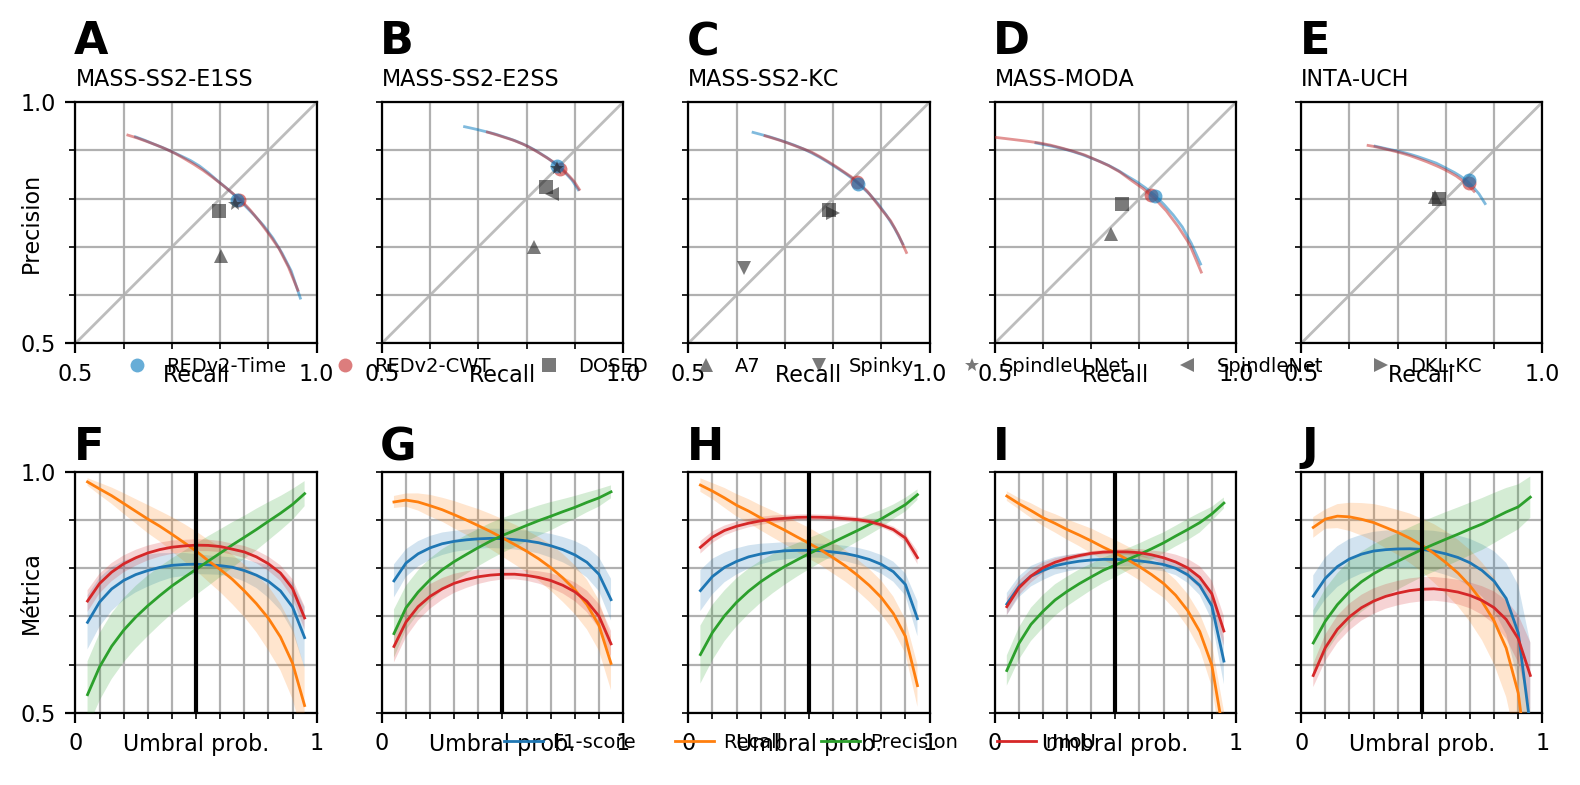

In [65]:
save_figure = True
markersize = 5
red_alpha = 0.6
pr_alpha_curve = 0.5
thr_alpha_curve = 1.0
baseline_color = viz.GREY_COLORS[9]
letters = ['A', 'B', 'C', 'D', 'E']
letters2 = ['F', 'G', 'H', 'I', 'J']
model_specs = {
    constants.V2_TIME: dict(marker='o', color=viz.PALETTE['blue']),
    constants.V2_CWT1D: dict(marker='o', color=viz.PALETTE['red']),
    'dosed': dict(marker='s', color=baseline_color),
    'a7': dict(marker='^', color=baseline_color),
    'spinky': dict(marker='v', color=baseline_color),
}
spindle_net = dict(metrics={"F1-score": .83, "Recall": .852, "Precision": .81}, marker='<', color=baseline_color)
dkl_kc = dict(metrics={"F1-score": .78, "Recall": .80, "Precision": .77}, marker='>', color=baseline_color)
sp_unet_1 = dict(metrics={"F1-score": .803, "Recall": .830, "Precision": .788}, marker='*', color=baseline_color)
sp_unet_2 = dict(metrics={"F1-score": .854, "Recall": .862, "Precision": .864}, marker='*', color=baseline_color)

fig, axes = plt.subplots(2, 5, figsize=(8, 4), dpi=200)
for i, config in enumerate(eval_configs):
    # PR PLOT
    ax = axes[0, i]
    metric_dict = metrics_list[i].to_dict('index')
    for model_name in metric_dict.keys():
        ax.plot(
            metric_dict[model_name]["Recall"], 
            metric_dict[model_name]["Precision"],
            linestyle="None",
            alpha=red_alpha,
            marker=model_specs[model_name]["marker"],
            markersize=markersize,
            markeredgewidth=0.0, zorder=20,
            color=model_specs[model_name]["color"],
            label=print_model_names[model_name])
    ax.set_title(print_dataset_names[(config["dataset_name"], config["expert"])], loc="left", fontsize=8)
    plotter.format_precision_recall_plot_simple(
        ax, axis_range=(0.5, 1), show_quadrants=False, show_grid=True,
        axis_markers=np.arange(0.5, 1 + 0.001, 0.5), minor_axis_markers=np.arange(0.5, 1 + 0.001, 0.1))
    ax.tick_params(labelsize=8)
    ax.set_xlabel("Recall", fontsize=8)
    if i == 0:
        ax.set_ylabel("Precision", fontsize=8) 
    else:
        ax.set_yticks([])
    # Get labels closer to axis
    ax.xaxis.labelpad = -8
    ax.yaxis.labelpad = -8
    # Add PR curve
    # [loc in config][model_name][fold_id][metric_name][loc in thr]
    pr_curve_data = metrics_curve_list[i]
    for model_name in pr_curve_data.keys():
        n_folds = len(pr_curve_data[model_name].keys())
        seeds_recall = [pr_curve_data[model_name][k]["Recall"] for k in range(n_folds)]
        seeds_precision = [pr_curve_data[model_name][k]["Precision"] for k in range(n_folds)]
        # Ignore the "come-back" of each individual curve before averaging
        new_seeds_recall = []
        new_seeds_precision = []
        for k in range(n_folds):
            fold_recall, fold_precision = fix_single_pr_curve(seeds_recall[k], seeds_precision[k])
            new_seeds_recall.append(fold_recall)
            new_seeds_precision.append(fold_precision)
        mean_recall_curve, mean_precision_curve = plotter.average_curves(new_seeds_recall, new_seeds_precision)
        ax.plot(
            mean_recall_curve, mean_precision_curve,
            linewidth=1.0, color=model_specs[model_name]["color"], zorder=10, alpha=pr_alpha_curve)

    if print_dataset_names[(config["dataset_name"], config["expert"])] == print_dataset_names[(constants.MASS_SS_NAME, 1)]:
        ax.plot(
            sp_unet_1["metrics"]["Recall"], 
            sp_unet_1["metrics"]["Precision"],
            linestyle="None",
            alpha=red_alpha,
            marker=sp_unet_1["marker"],
            markersize=markersize,
            markeredgewidth=0.0, zorder=20,
            color=sp_unet_1["color"],
            label="SpindleU-Net")
    if print_dataset_names[(config["dataset_name"], config["expert"])] == print_dataset_names[(constants.MASS_SS_NAME, 2)]:
        ax.plot(
            sp_unet_2["metrics"]["Recall"], 
            sp_unet_2["metrics"]["Precision"],
            linestyle="None",
            alpha=red_alpha,
            marker=sp_unet_2["marker"],
            markersize=markersize,
            markeredgewidth=0.0, zorder=20,
            color=sp_unet_2["color"],
            label="SpindleU-Net")
        ax.plot(
            spindle_net["metrics"]["Recall"], 
            spindle_net["metrics"]["Precision"],
            linestyle="None",
            alpha=red_alpha,
            marker=spindle_net["marker"],
            markersize=markersize,
            markeredgewidth=0.0, zorder=20,
            color=spindle_net["color"],
            label="SpindleNet")
    if print_dataset_names[(config["dataset_name"], config["expert"])] == print_dataset_names[(constants.MASS_KC_NAME, 1)]:
        ax.plot(
            dkl_kc["metrics"]["Recall"], 
            dkl_kc["metrics"]["Precision"],
            linestyle="None",
            alpha=red_alpha,
            marker=dkl_kc["marker"],
            markersize=markersize,
            markeredgewidth=0.0, zorder=20,
            color=dkl_kc["color"],
            label="DKL-KC")
    
    ax.text(
        x=-0.01, y=1.2, fontsize=16, s=r"$\bf{%s}$" % letters[i],
        ha="left", transform=ax.transAxes)
    
    # CHANGE DUE TO THR
    ax = axes[1, i]
    model_name = "v2_time"
    # for model_name in pr_curve_data.keys():
    
    n_folds = len(pr_curve_data[model_name].keys())
    seeds_metric = {
        metric_name: np.stack([pr_curve_data[model_name][k][metric_name] for k in range(n_folds)], axis=0)
        for metric_name in ["F1-score", "Recall", "Precision", "mIoU"]
    }
    for metric_name in ["F1-score", "Recall", "Precision", "mIoU"]:
        ax.plot(
            adjusted_thr_list, seeds_metric[metric_name].mean(axis=0), 
            linewidth=1.0, zorder=10, alpha=thr_alpha_curve, label=metric_name)
        ax.fill_between(
            adjusted_thr_list, 
            seeds_metric[metric_name].mean(axis=0) + seeds_metric[metric_name].std(axis=0), 
            seeds_metric[metric_name].mean(axis=0) - seeds_metric[metric_name].std(axis=0), 
            linewidth=1.0, zorder=10, alpha=0.2)
    ax.axvline(0.5, color="k", linewidth=1.5, zorder=30)
    ax.tick_params(labelsize=8)
    ax.set_xlabel("Umbral prob.", fontsize=8)
    ax.set_xlim([0, 1])
    ax.set_ylim([0.5, 1.0])
    ax.set_xticks([0, 1.0])
    ax.set_xticks(np.arange(0, 1 + 0.001, 0.1), minor=True)
    ax.set_yticks([0.5, 1.0])
    ax.set_yticks(np.arange(0.5, 1 + 0.001, 0.1), minor=True)
    ax.grid(which="minor")
    if i == 0:
        ax.set_ylabel("Métrica", fontsize=8) 
    else:
        ax.set_yticks([])
    ax.xaxis.labelpad = -8
    ax.yaxis.labelpad = -8
    ax.set_aspect(2)
    
    ax.text(
        x=-0.01, y=1.05, fontsize=16, s=r"$\bf{%s}$" % letters2[i],
        ha="left", transform=ax.transAxes)
    
plt.tight_layout()


# Get legend methods
labels_to_lines_dict = {}
for ax in axes[0, :]:
    t_lines, t_labels = ax.get_legend_handles_labels()
    for lbl, lin in zip(t_labels, t_lines):
        labels_to_lines_dict[lbl] = lin
labels = ["REDv2-Time", "REDv2-CWT", "DOSED", "A7", "Spinky", "SpindleU-Net", "SpindleNet", "DKL-KC"]
lines = [labels_to_lines_dict[lbl] for lbl in labels]
lg1 = fig.legend(
    lines, labels, fontsize=7, loc="lower center",
    bbox_to_anchor=(0.5, 0.49), ncol=len(labels), frameon=False, handletextpad=0.5)

# Get legend metrics
labels_to_lines_dict = {}
for ax in axes[1, :]:
    t_lines, t_labels = ax.get_legend_handles_labels()
    for lbl, lin in zip(t_labels, t_lines):
        labels_to_lines_dict[lbl] = lin
labels = ["F1-score", "Recall", "Precision", "mIoU"]
lines = [labels_to_lines_dict[lbl] for lbl in labels]
lg2 = fig.legend(
    lines, labels, fontsize=7, loc="lower center",
    bbox_to_anchor=(0.5, 0.02), ncol=len(labels), frameon=False, handletextpad=0.5)

if save_figure:
    # Save figure
    fname_prefix = "result_comparison_pr_thr"
    plt.savefig("%s.pdf" % fname_prefix, bbox_extra_artists=(lg1, lg2), bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.png" % fname_prefix, bbox_extra_artists=(lg1, lg2), bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.svg" % fname_prefix, bbox_extra_artists=(lg1, lg2), bbox_inches="tight", pad_inches=0.3)


plt.show()

# Efecto umbral IoU: F1 vs IoU, Histograma IoU

In [ ]:
models = [constants.V2_TIME, constants.V2_CWT1D]
baselines_ss = ['dosed', 'a7']
baselines_kc = ['dosed', 'spinky']
print_model_names = {
    constants.V2_TIME: 'REDv2-Time',
    constants.V2_CWT1D: 'REDv2-CWT',
    'dosed': 'DOSED',
    'a7': 'A7',
    'spinky': 'Spinky'
}
print_dataset_names = {
    (constants.MASS_SS_NAME, 1): "MASS-SS2-E1SS",
    (constants.MASS_SS_NAME, 2): "MASS-SS2-E2SS",
    (constants.MASS_KC_NAME, 1): "MASS-SS2-KC",
    (constants.MODA_SS_NAME, 1): "MASS-MODA",
    (constants.INTA_SS_NAME, 1): "INTA-UCH",
}

eval_configs = [
    dict(dataset_name=constants.MASS_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_SS_NAME, expert=2, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_KC_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MODA_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.INTA_SS_NAME, expert=1, strategy='5cv', seeds=3),
]

iou_curve_axis = np.arange(0.05, 0.95 + 0.001, 0.05)
iou_hist_bins = np.linspace(0, 1, 21)

metrics_list = []
for config in eval_configs:
    print("\nLoading", config)
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    baselines = baselines_ss if dataset.event_name == constants.SPINDLE else baselines_kc
    
    # Collect predictions
    pred_dict = {}
    for model_version in models:
        tmp_dict = fig_utils.get_red_predictions(model_version, config["strategy"], dataset, config["expert"], verbose=False)
        # Retrieve only predictions, same format as baselines
        pred_dict[model_version] = {}
        for k in tmp_dict.keys():
            fold_subjects = tmp_dict[k][constants.TEST_SUBSET].all_ids
            fold_predictions = tmp_dict[k][constants.TEST_SUBSET].get_stamps()
            pred_dict[model_version][k] = {s: pred for s, pred in zip(fold_subjects, fold_predictions)}
    for baseline_name in baselines:
        pred_dict[baseline_name] = fig_utils.get_baseline_predictions(baseline_name, config["strategy"], config["dataset_name"], config["expert"])
    # print("Loaded models:", pred_dict.keys())
    
    # Measure performance byfold
    average_mode = constants.MICRO_AVERAGE if (config["dataset_name"] == constants.MODA_SS_NAME) else constants.MACRO_AVERAGE
    _, _, test_ids_list = get_partitions(dataset, config["strategy"], config["seeds"])
    n_folds = len(test_ids_list)
    table = {'Detector': [], 'F1-score_vs_iou': [], 'IoU_hist': [], 'mIoU': [], 'Fold': []}
    for model_name in pred_dict.keys():
        for k in range(n_folds):
            subject_ids = test_ids_list[k]
            feed_d = FeederDataset(dataset, subject_ids, constants.N2_RECORD, which_expert=config["expert"])
            events_list = feed_d.get_stamps()
            detections_list = [pred_dict[model_name][k][subject_id] for subject_id in subject_ids]
            performance = fig_utils.compute_fold_performance_vs_iou(
                events_list, detections_list, average_mode, iou_curve_axis)
            iou_mean, iou_hist_values = fig_utils.compute_iou_histogram(
                performance['nonzero_IoU'], average_mode, iou_hist_bins)
            table['Detector'].append(model_name)
            table['F1-score_vs_iou'].append(performance['F1-score_vs_iou'])
            table['IoU_hist'].append(iou_hist_values)
            table['mIoU'].append(iou_mean)
            table['Fold'].append(k)
    table = pd.DataFrame.from_dict(table)
    print("By-fold statistics")
    metric_mean = table.groupby(by=["Detector"]).apply(np.mean).drop(columns=["Fold"])
    metrics_list.append(metric_mean)
print("Metrics computed.")

In [ ]:
save_figure = True
markersize = 4
f1_alpha_curve = 1.0
iou_thr_reported = 0.2
f1_markers_iou = [0.2, 0.4, 0.6, 0.8]

idx_markers_iou = [
    misc.closest_index(single_marker, iou_curve_axis) 
    for single_marker in f1_markers_iou]

baseline_color = viz.GREY_COLORS[8]
letters = ['A', 'B', 'C', 'D', 'E']
letters2 = ['F', 'G', 'H', 'I', 'J']
model_specs = {
    constants.V2_TIME: dict(marker='o', color=viz.PALETTE['blue']),
    constants.V2_CWT1D: dict(marker='o', color=viz.PALETTE['red']),
    'dosed': dict(marker='s', color=baseline_color),
    'a7': dict(marker='^', color=baseline_color),
    'spinky': dict(marker='v', color=baseline_color),
}
spindle_net = dict(metrics={"F1-score": .83, "Recall": .852, "Precision": .81}, marker='<', color=baseline_color)
dkl_kc = dict(metrics={"F1-score": .78, "Recall": .80, "Precision": .77}, marker='>', color=baseline_color)

fig, axes = plt.subplots(2, 5, figsize=(8, 4.5), dpi=200)
for i, config in enumerate(eval_configs):
    # F1-score vs IoU
    ax = axes[0, i]
    metric_dict = metrics_list[i].to_dict('index')
    for model_name in metric_dict.keys():
        ax.plot(
            iou_curve_axis, 
            metric_dict[model_name]["F1-score_vs_iou"],
            linewidth=1,
            marker=model_specs[model_name]["marker"],
            markersize=markersize,
            alpha=f1_alpha_curve,
            markeredgewidth=0.0, zorder=20,
            color=model_specs[model_name]["color"],
            label=print_model_names[model_name],
            markevery=idx_markers_iou)
    ax.set_title(print_dataset_names[(config["dataset_name"], config["expert"])], loc="left", fontsize=8)
    # ax.axvline(iou_thr_reported, color="k", linewidth=1.5, zorder=5, alpha=0.5)
    ax.tick_params(labelsize=8)
    ax.set_xlabel("Umbral IoU", fontsize=8)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xticks([0, 1.0])
    ax.set_xticks(np.arange(0, 1 + 0.001, 0.1), minor=True)
    ax.set_yticks([0, 1.0])
    ax.set_yticks(np.arange(0, 1 + 0.001, 0.1), minor=True)
    ax.grid(which="minor")
    if i == 0:
        ax.set_ylabel("F1-score", fontsize=8) 
    else:
        ax.set_yticks([])
    ax.xaxis.labelpad = -8
    ax.yaxis.labelpad = -8
    ax.set_aspect("equal")
    
    ax.text(
        x=-0.01, y=1.2, fontsize=16, s=r"$\bf{%s}$" % letters[i],
        ha="left", transform=ax.transAxes)
    
    # IoU Hist
    ax = axes[1, i]
    max_value = 0
    for model_name in metric_dict.keys():
        max_value = max(metric_dict[model_name]["IoU_hist"].max(), max_value)
    max_value = max_value * 1.3
    n_cases = len(metric_dict.keys())
    y_sep = 1 / n_cases
    this_center = 1 - y_sep
    
    model_names = list(metric_dict.keys())
    reference_order = [constants.V2_TIME, constants.V2_CWT1D, "dosed", "a7", "spinky"]
    model_names_sorted = [n for n in reference_order if n in model_names]
    
    for i_offset, model_name in enumerate(model_names_sorted):
        x, y = plotter.piecewise_constant_histogram(
            iou_hist_bins, metric_dict[model_name]["IoU_hist"])
        y = y_sep * y / max_value
        ax.plot(
            [metric_dict[model_name]["mIoU"], metric_dict[model_name]["mIoU"]], 
            [this_center, this_center + 0.8*y_sep],
            linewidth=1.5, color="k", zorder=25, label='mIoU')
        ax.fill_between(
            x, this_center + y, this_center,
            edgecolor=model_specs[model_name]["color"], linewidth=1,
            facecolor=viz.GREY_COLORS[3], zorder=20)
        ax.plot(
            0.05, this_center + 0.2*y_sep, 
            markersize=markersize, c=model_specs[model_name]["color"], zorder=15, 
            marker=model_specs[model_name]["marker"], linestyle="None")
        this_center = this_center - y_sep
        if i_offset == 0:
            lg = ax.legend(loc='upper left', fontsize=8, frameon=False, bbox_to_anchor=(0, 1.05))
            
    ax.tick_params(labelsize=8)
    ax.set_xlabel("IoU de par", fontsize=8)
    ax.set_xlim([0, 1])
    ax.set_xticks([0, 1.0])
    ax.set_xticks(np.arange(0, 1 + 0.001, 0.1), minor=True)
    ax.xaxis.labelpad = -8
    if i == 0:
        ax.set_ylabel("Densidad", fontsize=8)
    ax.set_ylim([0, 1])
    ax.set_yticks([])
    ax.grid(axis="x", which="minor")
    ax.set_aspect("equal")
    
    ax.text(
        x=-0.01, y=1.05, fontsize=16, s=r"$\bf{%s}$" % letters2[i],
        ha="left", transform=ax.transAxes)
    
plt.tight_layout()

# Get legend methods
labels_to_lines_dict = {}
for ax in axes[0, :]:
    t_lines, t_labels = ax.get_legend_handles_labels()
    for lbl, lin in zip(t_labels, t_lines):
        labels_to_lines_dict[lbl] = lin
labels = ["REDv2-Time", "REDv2-CWT", "DOSED", "A7", "Spinky"]
lines = [labels_to_lines_dict[lbl] for lbl in labels]
lg1 = fig.legend(
    lines, labels, fontsize=7, loc="lower center",
    bbox_to_anchor=(0.5, 0.49), ncol=len(labels), frameon=False, handletextpad=0.5)

if save_figure:
    # Save figure
    fname_prefix = "result_comparison_f1_iou"
    plt.savefig("%s.pdf" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.png" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.svg" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.4)

plt.show()

# Parameters: By-event overlap
[5CV only, MODA y MASS-KC, by-event all-in] matches individuales: duracion real vs predicha (ajuste lineal y R2), duracion real vs IoU  ¿scatter o hist2D?


In [ ]:
def get_durations(events_list, detections_list):
    # iou_matching = []  # Array for IoU for every true event (gs)
    # idx_matching = []  # Array for the index associated with the true event.
    _, idx_matching_list = metrics.matching_with_list(events_list, detections_list)
    durations_real_list = []
    durations_pred_list = []
    for i in range(len(events_list)):
        events = events_list[i]
        detections = detections_list[i]
        if events.size == 0 or detections.size == 0:
            continue
        idx_matching = idx_matching_list[i]
        valid_event_locs = np.where(idx_matching != -1)[0]
        if valid_event_locs.size == 0:
            continue
        events_m = events[valid_event_locs]
        detections_m = detections[idx_matching[valid_event_locs]]
        durations_real = events_m[:, 1] - events_m[:, 0] + 1
        durations_pred = detections_m[:, 1] - detections_m[:, 0] + 1
        durations_real_list.append(durations_real)
        durations_pred_list.append(durations_pred)
    durations_real_list = np.concatenate(durations_real_list)
    durations_pred_list = np.concatenate(durations_pred_list)
    return durations_real_list, durations_pred_list

In [ ]:
models = [constants.V2_TIME, constants.V2_CWT1D]
baselines_ss = ['dosed', 'a7']
baselines_kc = ['dosed', 'spinky']
print_model_names = {
    constants.V2_TIME: 'REDv2-Time',
    constants.V2_CWT1D: 'REDv2-CWT',
    'dosed': 'DOSED',
    'a7': 'A7',
    'spinky': 'Spinky'
}
print_dataset_names = {
    (constants.MASS_SS_NAME, 1): "MASS-SS2-E1SS",
    (constants.MASS_SS_NAME, 2): "MASS-SS2-E2SS",
    (constants.MASS_KC_NAME, 1): "MASS-SS2-KC",
    (constants.MODA_SS_NAME, 1): "MASS-MODA",
    (constants.INTA_SS_NAME, 1): "INTA-UCH",
}

eval_configs = [
    dict(dataset_name=constants.MODA_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_KC_NAME, expert=1, strategy='5cv', seeds=3),
]

metrics_list = []
for config in eval_configs:
    print("\nLoading", config)
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    baselines = baselines_ss if dataset.event_name == constants.SPINDLE else baselines_kc
    
    # Collect predictions
    pred_dict = {}
    for model_version in models:
        tmp_dict = fig_utils.get_red_predictions(model_version, config["strategy"], dataset, config["expert"], verbose=False)
        # Retrieve only predictions, same format as baselines
        pred_dict[model_version] = {}
        for k in tmp_dict.keys():
            fold_subjects = tmp_dict[k][constants.TEST_SUBSET].all_ids
            fold_predictions = tmp_dict[k][constants.TEST_SUBSET].get_stamps()
            pred_dict[model_version][k] = {s: pred for s, pred in zip(fold_subjects, fold_predictions)}
    for baseline_name in baselines:
        pred_dict[baseline_name] = fig_utils.get_baseline_predictions(baseline_name, config["strategy"], config["dataset_name"], config["expert"])
    # print("Loaded models:", pred_dict.keys())
    
    # Retrieve matchings (it does not matter macro or micro because all events are grouped together)
    _, _, test_ids_list = get_partitions(dataset, config["strategy"], config["seeds"])
    n_folds = len(test_ids_list)
    table = {'Detector': [], 'Duration_real': [], 'Duration_pred': []}
    for model_name in pred_dict.keys():
        durations_real_list = []
        durations_pred_list = []
        for k in range(n_folds):
            subject_ids = test_ids_list[k]
            feed_d = FeederDataset(dataset, subject_ids, constants.N2_RECORD, which_expert=config["expert"])
            events_list = feed_d.get_stamps()
            detections_list = [pred_dict[model_name][k][subject_id] for subject_id in subject_ids]
            durations_real, durations_pred = get_durations(events_list, detections_list)
            durations_real_list.append(durations_real)
            durations_pred_list.append(durations_pred)
        durations_real_list = np.concatenate(durations_real_list).astype(np.float32) / dataset.fs
        durations_pred_list = np.concatenate(durations_pred_list).astype(np.float32) / dataset.fs
        table['Detector'].append(model_name)
        table['Duration_real'].append(durations_real_list)
        table['Duration_pred'].append(durations_pred_list)
    metrics_list.append(table)
print("Metrics computed.")

In [ ]:
save_figure = True

use_hist = True
hist_temp_res = 0.05
scatter_alpha = 0.01
baseline_color = viz.GREY_COLORS[8]
letters = ['A', 'B', 'C', 'D']
letters2 = ['E', 'F', 'G', 'H']
model_specs = {
    constants.V2_TIME: dict(marker='o', color=viz.PALETTE['blue']),
    constants.V2_CWT1D: dict(marker='o', color=viz.PALETTE['red']),
    'dosed': dict(marker='s', color=baseline_color),
    'a7': dict(marker='^', color=baseline_color),
    'spinky': dict(marker='v', color=baseline_color),
}

fig, axes = plt.subplots(2, 4, figsize=(8, 4.7), dpi=200, sharex=True, sharey=True)
for i, config in enumerate(eval_configs):
    
    max_dur = 2 #3 if 'moda' in config["dataset_name"] else 3
    
    x_bins = np.arange(0, max_dur + 0.001, hist_temp_res)
    y_bins = np.arange(0, max_dur + 0.001, hist_temp_res)
    x_centers = x_bins[:-1] + x_bins[1]/2 - x_bins[0]/2
    y_centers = y_bins[:-1] + y_bins[1]/2 - y_bins[0]/2
    xv, yv = np.meshgrid(x_centers, y_centers)
    
    # Duration scatter
    axx = axes[i, :]
    metric_dict = metrics_list[i]
    n_models = len(metric_dict['Detector'])
    print("\nDatos & Detector & R2 & Mean Error & Std Error \\\\")
    for j in range(n_models):
        model_name = metric_dict['Detector'][j]
        x_data = metric_dict['Duration_real'][j]
        y_data = metric_dict['Duration_pred'][j]
        ax = axx[j]
        if use_hist:
            hist, _, _ = np.histogram2d(
                x_data, y_data, 
                bins=[x_bins, y_bins], density=True)
            ax.hist2d(
                xv.flatten(), yv.flatten(), bins=[x_bins, y_bins], weights=np.transpose(hist).flatten(), cmap='Blues')
        else:
            ax.plot(
                x_data, y_data, 
                linestyle='None', marker='o', markersize=3, alpha=scatter_alpha, markeredgewidth=0.0)
        dataset_str = print_dataset_names[(config["dataset_name"], config["expert"])]
        model_str = print_model_names[model_name]
        ax.set_title('%s, %s' % (model_str, dataset_str), loc="left", fontsize=8)
        ax.tick_params(labelsize=8)
        ax.set_xlim([0, max_dur])
        ax.set_ylim([0, max_dur])
        ax.set_xticks([0, max_dur])
        ax.set_yticks([0, max_dur])
        ax.set_xticks(np.arange(0, max_dur + 0.001, 0.5), minor=True)
        ax.set_yticks(np.arange(0, max_dur + 0.001, 0.5), minor=True)
        ax.set_aspect('equal')
        ax.xaxis.labelpad = -7
        ax.yaxis.labelpad = -7
        ax.grid(which="minor")
        ax.plot([0, max_dur], [0, max_dur], color=viz.GREY_COLORS[4], linewidth=0.7, zorder=5)
        # fig_utils.linear_regression(metric_dict['Duration_real'][j], metric_dict['Duration_pred'][j], 0.3, 1.7, ax)
        r2_score = fig_utils.linear_regression(
            x_data, y_data, 
            0.3, 1.7, ax,
            frameon=False, fontsize=8, loc="lower right", bbox_to_anchor=(1.05, -0.05)
        )
        ax.plot(
            np.mean(x_data), 
            np.mean(y_data), 
            linestyle="None", marker='o', zorder=30,
            markersize=6, markeredgewidth=0.0, color=viz.PALETTE['red'])
        # print(dataset_str, "max",metric_dict['Duration_real'][j].max(), "prct", np.percentile(metric_dict['Duration_real'][j], 98))
        if i == 1:
            axes[i, j].set_xlabel("Duración real (s)", fontsize=8)
        letters_selected = letters if i == 0 else letters2
        ax.text(
            x=-0.01, y=1.15, fontsize=16, s=r"$\bf{%s}$" % letters_selected[j],
            ha="left", transform=ax.transAxes)
        # Print quantitative data
        error_data = y_data - x_data  #  pred - real
        print("%s & %s & %1.2f & %1.4f (s) & %1.4f (s) \\\\" % (
            dataset_str, model_str, r2_score, np.mean(error_data), np.std(error_data)
        ))
            
    axes[i, 0].set_ylabel("Duración predicha (s)", fontsize=8)
        
plt.tight_layout()

if save_figure:
    # Save figure
    fname_prefix = "result_comparison_durations"
    plt.savefig("%s.pdf" % fname_prefix, bbox_inches="tight", pad_inches=0.01)
    plt.savefig("%s.png" % fname_prefix, bbox_inches="tight", pad_inches=0.01)
    plt.savefig("%s.svg" % fname_prefix, bbox_inches="tight", pad_inches=0.01)

plt.show()

# Parameters: By-event parameter distributions

In [ ]:
models = [constants.V2_TIME, constants.V2_CWT1D]
baselines_ss = ['dosed', 'a7']
baselines_kc = ['dosed', 'spinky']
print_dataset_names = {
    (constants.MASS_SS_NAME, 1): "MASS-SS2-E1SS",
    (constants.MASS_SS_NAME, 2): "MASS-SS2-E2SS",
    (constants.MASS_KC_NAME, 1): "MASS-SS2-KC",
    (constants.MODA_SS_NAME, 1): "MASS-MODA",
    (constants.INTA_SS_NAME, 1): "INTA-UCH",
}

eval_configs = [
    dict(dataset_name=constants.MODA_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_KC_NAME, expert=1, strategy='5cv', seeds=3),
]

metrics_list = []
for config in eval_configs:
    print("\nLoading", config)
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    baselines = baselines_ss if dataset.event_name == constants.SPINDLE else baselines_kc
    
    # Collect predictions
    pred_dict = {}
    for model_version in models:
        tmp_dict = fig_utils.get_red_predictions(model_version, config["strategy"], dataset, config["expert"], verbose=False)
        # Retrieve only predictions, same format as baselines
        pred_dict[model_version] = {}
        for k in tmp_dict.keys():
            fold_subjects = tmp_dict[k][constants.TEST_SUBSET].all_ids
            fold_predictions = tmp_dict[k][constants.TEST_SUBSET].get_stamps()
            pred_dict[model_version][k] = {s: pred for s, pred in zip(fold_subjects, fold_predictions)}
    for baseline_name in baselines:
        pred_dict[baseline_name] = fig_utils.get_baseline_predictions(baseline_name, config["strategy"], config["dataset_name"], config["expert"])
    # print("Loaded models:", pred_dict.keys())
    
    # Retrieve parameters, all events together
    stat_spindle = (config["dataset_name"] == constants.MODA_SS_NAME)
    _, _, test_ids_list = get_partitions(dataset, config["strategy"], config["seeds"])
    n_folds = len(test_ids_list)
    table = {
        'Detector': [],
        'Duration': [], 
        'AmplitudePP': [],
        'Frequency': [],
    }
    # Insert GS first
    tmp_table = {
        'Duration': [], 
        'AmplitudePP': [],
        'Frequency': [],
    }
    for k in range(n_folds):
        subject_ids = test_ids_list[k]
        feed_d = FeederDataset(dataset, subject_ids, constants.N2_RECORD, which_expert=config["expert"])
        events_list = feed_d.get_stamps()
        for i_sub, subject_id in enumerate(subject_ids):
            events = events_list[i_sub]
            if events.size == 0:
                continue
            # Duration
            duration = (events[:, 1] - events[:, 0] + 1) / dataset.fs
            tmp_table['Duration'].append(duration)
            # Amplitude
            signal = dataset.get_subject_signal(subject_id, normalize_clip=False)
            event_name = 'spindle' if stat_spindle else 'kcomplex'
            filt_signal = param_filtering_fn(signal, dataset.fs, event_name)
            signal_events = [filt_signal[e[0]:e[1]+1] for e in events]
            amplitude = np.array([param_amplitude_fn(s, dataset.fs, event_name) for s in signal_events])
            tmp_table['AmplitudePP'].append(amplitude)
            # Frequency
            if stat_spindle:
                freq_central = np.array([param_frequency_fn(s, dataset.fs) for s in signal_events])
            else:
                freq_central = np.array([1] * len(signal_events))
            tmp_table['Frequency'].append(freq_central)
    table['Detector'].append('Expert')
    for key in tmp_table.keys():
        table[key].append(np.concatenate(tmp_table[key]))
        
    # Now detectors
    for model_name in pred_dict.keys():
        tmp_table = {
            'Duration': [], 
            'AmplitudePP': [],
            'Frequency': [],
        }
        for k in range(n_folds):
            subject_ids = test_ids_list[k]
            feed_d = FeederDataset(dataset, subject_ids, constants.N2_RECORD, which_expert=config["expert"])
            detections_list = [pred_dict[model_name][k][subject_id] for subject_id in subject_ids]
            for i_sub, subject_id in enumerate(subject_ids):
                detections = detections_list[i_sub]
                if detections.size == 0:
                    continue
                # Duration
                duration = (detections[:, 1] - detections[:, 0] + 1) / dataset.fs
                tmp_table['Duration'].append(duration)
                # Amplitude
                signal = dataset.get_subject_signal(subject_id, normalize_clip=False)
                event_name = 'spindle' if stat_spindle else 'kcomplex'
                filt_signal = param_filtering_fn(signal, dataset.fs, event_name)
                signal_events = [filt_signal[e[0]:e[1]+1] for e in detections]
                amplitude = np.array([param_amplitude_fn(s, dataset.fs, event_name) for s in signal_events])
                tmp_table['AmplitudePP'].append(amplitude)
                # Frequency
                if stat_spindle:
                    freq_central = np.array([param_frequency_fn(s, dataset.fs) for s in signal_events])
                else:
                    freq_central = np.array([1] * len(signal_events))
                tmp_table['Frequency'].append(freq_central) 
        table['Detector'].append(model_name)
        for key in tmp_table.keys():
            table[key].append(np.concatenate(tmp_table[key]))
    metrics_list.append(table)
print("Metrics computed.")

In [ ]:
save_figure = True

print_model_names = {
    constants.V2_TIME: 'REDv2-Time',
    constants.V2_CWT1D: 'REDv2-CWT',
    'dosed': 'DOSED',
    'a7': 'A7',
    'spinky': 'Spinky',
    'Expert': 'Anotación'
}
print_parameter = {
    'Duration': 'Duración (s)', 'AmplitudePP': 'Amplitud PP ($\mu$V)', 'Frequency': 'Frecuencia (Hz)'
}

min_values_forced = [0, 0, 9, 0, 0]
max_values_forced = [3, 150, 17, 2, 600]
major_ticks_forced = [[0, 1, 2, 3], [0, 50, 100, 150], [9, 11, 13, 15, 17], [0, 1, 2], [0, 200, 400, 600]]
minor_ticks_step_forced = [0.5, 25, 1, 0.5, 100]

markersize = 8
baseline_color = viz.GREY_COLORS[6]
model_specs = {
    constants.V2_TIME: dict(marker='o', color=viz.PALETTE['blue']),
    constants.V2_CWT1D: dict(marker='o', color=viz.PALETTE['red']),
    'dosed': dict(marker='s', color=baseline_color),
    'a7': dict(marker='^', color=baseline_color),
    'spinky': dict(marker='v', color=baseline_color),
    'Expert': dict(marker='p', color="k"),  # "#F9A825"
}

letters = ['A', 'B', 'C', 'D', 'E']
fig, axes = plt.subplots(1, 5, figsize=(8, 3), dpi=200)
j = 0
order_models_reference = ['Expert', constants.V2_TIME, constants.V2_CWT1D, 'dosed', 'a7', 'spinky']
for i_config, config in enumerate(eval_configs):
    metric_dict = metrics_list[i_config]
    n_models = len(metric_dict['Detector'])
    dataset_str = print_dataset_names[(config["dataset_name"], config["expert"])]
    print("Processing", dataset_str)
    dpi = 200
    if config["dataset_name"] == constants.MODA_SS_NAME:
        param_names = ['Duration', 'AmplitudePP', 'Frequency']
    else:
        param_names = ['Duration', 'AmplitudePP']
    for param_name in param_names:
        ax = axes[j]
        model_to_data = {m: d for m, d in zip(metric_dict['Detector'], metric_dict[param_name])}
        this_order = [m for m in order_models_reference if m in metric_dict['Detector']]
        this_order = this_order[::-1]
        x_data_list = [model_to_data[model_name] for model_name in this_order]
        positions = np.arange(len(x_data_list))
        parts = ax.violinplot(
            x_data_list, vert=False, showextrema=False, positions=positions, widths=0.8
        )
        for i_pc, pc in enumerate(parts['bodies']):
            pc.set_facecolor(viz.GREY_COLORS[3])
            pc.set_edgecolor(model_specs[this_order[i_pc]]["color"])
            pc.set_linewidth(0.7)
            pc.set_alpha(1.0)
            pc.set_zorder(20)
        for i_data, x_data in enumerate(x_data_list):
            mean_val = x_data.mean()
            model_name = this_order[i_data]
            ax.plot(
                mean_val, i_data, marker="x",#model_specs[model_name]["marker"], 
                color=model_specs[model_name]["color"], linestyle="None", zorder=30,
                markersize=4)
            low_iqr, high_iqr = np.percentile(x_data, (25, 75))
            ax.plot(
                [low_iqr, high_iqr], [i_data, i_data], linewidth=0.8, zorder=30,
                color=model_specs[model_name]["color"])
            # ax.plot([mean_val, mean_val], [i_data + 0.4, i_data - 0.4], linewidth=1, color=model_specs[this_order[i_data]]["color"])
            if this_order[i_data] == 'Expert':
                ax.axvline(mean_val, linewidth=0.8, alpha=1.0, color=model_specs[model_name]["color"], zorder=35, linestyle="--")
                print("Param %s, Detector %s, Min %1.4f, Prctl33 %1.4f, prctl50 %1.4f, Prctl66 %1.4f, Max %1.4f" % (
                    param_name, model_name, x_data.min(), np.percentile(x_data, 33), np.percentile(x_data, 50), np.percentile(x_data, 66), x_data.max()
                ))

        min_pos_true = min_values_forced[j]
        max_pos_true = max_values_forced[j]
        for i_model, model_name in enumerate(this_order):
            ax.plot(
                min_pos_true - 0.1 * (max_pos_true - min_pos_true), i_model, 
                markersize=markersize, color=model_specs[model_name]["color"], zorder=30, markeredgewidth=0.0,
                label=print_model_names[model_name],
                marker=model_specs[model_name]["marker"], linestyle="None")
        min_pos_lim = min_pos_true - 0.2 * (max_pos_true - min_pos_true)
        ax.set_xlim([min_pos_lim, max_pos_true])
        ax.set_xticks(major_ticks_forced[j])
        ax.set_xticks(
            np.arange(
                major_ticks_forced[j][0], 
                major_ticks_forced[j][-1]+0.001, 
                minor_ticks_step_forced[j]
            ), minor=True)
        ax.set_title(dataset_str, fontsize=8, loc="left")
        ax.tick_params(labelsize=8)
        ax.set_yticks([])
        ax.set_xlabel(print_parameter[param_name], fontsize=8)
        ax.text(
            x=-0.01, y=1.12, fontsize=16, s=r"$\bf{%s}$" % letters[j],
            ha="left", transform=ax.transAxes)
        ax.xaxis.set_label_coords(0.6, -0.12)
        j = j + 1
        ax.grid(axis="x", which="minor")
        
plt.tight_layout()

# Get legend methods
labels_to_lines_dict = {}
for ax in axes:
    t_lines, t_labels = ax.get_legend_handles_labels()
    for lbl, lin in zip(t_labels, t_lines):
        labels_to_lines_dict[lbl] = lin
labels = ["Anotación", "REDv2-Time", "REDv2-CWT", "DOSED", "A7", "Spinky"]
lines = [labels_to_lines_dict[lbl] for lbl in labels]
lg1 = fig.legend(
    lines, labels, fontsize=7, loc="lower center",
    bbox_to_anchor=(0.5, 0.05), ncol=len(labels), frameon=False, handletextpad=0.5)

if save_figure:
    # Save figure
    fname_prefix = "result_comparison_byevent_params"
    plt.savefig("%s.pdf" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.png" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.svg" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.4)

plt.show()

# Parameters: By-subject parameters
[5CV only, MODA y MASS-KC, by-subject, pintar por fase] parámetro experto vs modelo, mostrando ajuste lineal y R2: duracion promedio, densidad promedio, amplitud PP promedio, y PR (maxSigma/broadNoDelta) promedio (only SS).

In [ ]:
models = [constants.V2_TIME, constants.V2_CWT1D]
baselines_ss = ['dosed', 'a7']
baselines_kc = ['dosed', 'spinky']
print_model_names = {
    constants.V2_TIME: 'REDv2-Time',
    constants.V2_CWT1D: 'REDv2-CWT',
    'dosed': 'DOSED',
    'a7': 'A7',
    'spinky': 'Spinky'
}
print_dataset_names = {
    (constants.MASS_SS_NAME, 1): "MASS-SS2-E1SS",
    (constants.MASS_SS_NAME, 2): "MASS-SS2-E2SS",
    (constants.MASS_KC_NAME, 1): "MASS-SS2-KC",
    (constants.MODA_SS_NAME, 1): "MASS-MODA",
    (constants.INTA_SS_NAME, 1): "INTA-UCH",
}

eval_configs = [
    dict(dataset_name=constants.MODA_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_KC_NAME, expert=1, strategy='5cv', seeds=3),
]

metrics_list = []
for config in eval_configs:
    print("\nLoading", config)
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    baselines = baselines_ss if dataset.event_name == constants.SPINDLE else baselines_kc
    
    # Collect predictions
    pred_dict = {}
    for model_version in models:
        tmp_dict = fig_utils.get_red_predictions(model_version, config["strategy"], dataset, config["expert"], verbose=False)
        # Retrieve only predictions, same format as baselines
        pred_dict[model_version] = {}
        for k in tmp_dict.keys():
            fold_subjects = tmp_dict[k][constants.TEST_SUBSET].all_ids
            fold_predictions = tmp_dict[k][constants.TEST_SUBSET].get_stamps()
            pred_dict[model_version][k] = {s: pred for s, pred in zip(fold_subjects, fold_predictions)}
    for baseline_name in baselines:
        pred_dict[baseline_name] = fig_utils.get_baseline_predictions(baseline_name, config["strategy"], config["dataset_name"], config["expert"])
    # print("Loaded models:", pred_dict.keys())
    
    # Retrieve by subject parameters (MODA only if 10 blocks)
    if config["dataset_name"] == constants.MODA_SS_NAME:
        valid_subjects = [sub_id for sub_id in dataset.all_ids if dataset.data[sub_id]['n_blocks'] == 10]
        phase_subjects = {sub_id: dataset.data[sub_id]['phase'] for sub_id in valid_subjects}
        stat_spindle = True
    else:
        valid_subjects = dataset.all_ids
        phase_subjects = {sub_id: 1 for sub_id in valid_subjects}
        stat_spindle = False
    _, _, test_ids_list = get_partitions(dataset, config["strategy"], config["seeds"])
    n_folds = len(test_ids_list)
    table = {
        'Detector': [], 
        'Phase': [],
        'Duration_mean_real': [], 
        'Duration_mean_pred': [], 
        'Density_real': [],
        'Density_pred': [],
        'AmplitudePP_mean_real': [],
        'AmplitudePP_mean_pred': [],
        'Frequency_mean_real': [],
        'Frequency_mean_pred': [],
    }
    for model_name in pred_dict.keys():
        tmp_table = {
            'Phase': [],
            'Duration_mean_real': [], 
            'Duration_mean_pred': [], 
            'Density_real': [],
            'Density_pred': [],
            'AmplitudePP_mean_real': [],
            'AmplitudePP_mean_pred': [],
            'Frequency_mean_real': [],
            'Frequency_mean_pred': [],
        }
        for k in range(n_folds):
            subject_ids = test_ids_list[k]
            feed_d = FeederDataset(dataset, subject_ids, constants.N2_RECORD, which_expert=config["expert"])
            events_list = feed_d.get_stamps()
            detections_list = [pred_dict[model_name][k][subject_id] for subject_id in subject_ids]
            for i_sub, subject_id in enumerate(subject_ids):
                if subject_id not in valid_subjects:
                    continue
                events = events_list[i_sub]
                detections = detections_list[i_sub]
                if events.size * detections.size == 0:
                    print("Skipped subject,", config["dataset_name"], model_name, "Events shape", events.shape, "Detections shape", detections.shape)
                    continue
                if events.shape[0] < 10:
                    print("Skipped subject", subject_id, "due to too few spindles, events:", events.shape)
                    continue
                    
                tmp_table['Phase'].append(phase_subjects[subject_id])
                    
                # Duration
                duration_real = np.mean((events[:, 1] - events[:, 0] + 1) / dataset.fs)
                duration_pred = np.mean((detections[:, 1] - detections[:, 0] + 1) / dataset.fs)
                tmp_table['Duration_mean_real'].append(duration_real)
                tmp_table['Duration_mean_pred'].append(duration_pred)
                
                # Density
                n2_pages = dataset.get_subject_pages(subject_id, pages_subset=constants.N2_RECORD)
                n2_minutes = n2_pages.size * dataset.page_duration / 60
                density_real = events.shape[0] / n2_minutes
                density_pred = detections.shape[0] / n2_minutes
                tmp_table['Density_real'].append(density_real)
                tmp_table['Density_pred'].append(density_pred)
                
                # Amplitude
                signal = dataset.get_subject_signal(subject_id, normalize_clip=False)
                event_name = 'spindle' if stat_spindle else 'kcomplex'
                filt_signal = param_filtering_fn(signal, dataset.fs, event_name)
                signal_events = [filt_signal[e[0]:e[1]+1] for e in events]
                signal_detections = [filt_signal[e[0]:e[1]+1] for e in detections]
                amplitude_real = np.mean([param_amplitude_fn(s, dataset.fs, event_name) for s in signal_events])
                amplitude_pred = np.mean([param_amplitude_fn(s, dataset.fs, event_name) for s in signal_detections])
                tmp_table['AmplitudePP_mean_real'].append(amplitude_real)
                tmp_table['AmplitudePP_mean_pred'].append(amplitude_pred)
                
                # Frequency
                if config["dataset_name"] == constants.MODA_SS_NAME:
                    freq_real = np.array([param_frequency_fn(s, dataset.fs) for s in signal_events]).mean()
                    freq_pred = np.array([param_frequency_fn(s, dataset.fs) for s in signal_detections]).mean()
                else:
                    freq_real = 1
                    freq_pred = 1
                #if np.abs(freq_real - freq_pred) > 0.5:
                    #print(config["dataset_name"], model_name, subject_id, phase_subjects[subject_id], events.shape, freq_real, detections.shape, freq_pred)
                tmp_table['Frequency_mean_real'].append(freq_real)
                tmp_table['Frequency_mean_pred'].append(freq_pred)
        table['Detector'].append(model_name)
        for key in tmp_table.keys():
            table[key].append(tmp_table[key])
    metrics_list.append(table)
print("Metrics computed.")

In [ ]:
save_figure = True

scatter_alpha = 0.5
markersize = 3
baseline_color = viz.GREY_COLORS[8]
letters = ['A', 'B', 'C', 'D']
letters2 = ['E', 'F', 'G', 'H']
letters3 = ['I', 'J', 'K', 'L']
letters4 = ['M', 'N', 'O', 'P']
model_specs = {
    constants.V2_TIME: dict(marker='o', color=viz.PALETTE['blue']),
    constants.V2_CWT1D: dict(marker='o', color=viz.PALETTE['red']),
    'dosed': dict(marker='s', color=baseline_color),
    'a7': dict(marker='^', color=baseline_color),
    'spinky': dict(marker='v', color=baseline_color),
}
print_name = {
    'Duration_mean': 'Duración', 'Density': 'Densidad', 'AmplitudePP_mean': 'Amplitud PP', 'Frequency_mean': 'Frecuencia'
}
units = {
    'Duration_mean': 's', 'Density': 'epm', 'AmplitudePP_mean': '$\mu$V', 'Frequency_mean': 'Hz'
}
decimals = {
    'Duration_mean': 1, 'Density': 0, 'AmplitudePP_mean': -1, 'Frequency_mean': 0
}
resolutions = {
    'Duration_mean': 0.1, 'Density': 1, 'AmplitudePP_mean': 10, 'Frequency_mean': 0.5
}
for i_config, config in enumerate(eval_configs):
    metric_dict = metrics_list[i_config]
    n_models = len(metric_dict['Detector'])
    dataset_str = print_dataset_names[(config["dataset_name"], config["expert"])]
    print("Processing", dataset_str)
    dpi = 200
    if config["dataset_name"] == constants.MODA_SS_NAME:
        fig, axes = plt.subplots(4, 4, figsize=(8, 9), dpi=dpi)
        param_names = ['Duration_mean', 'Density', 'AmplitudePP_mean', 'Frequency_mean']
    else:
        fig, axes = plt.subplots(3, 4, figsize=(8, 7), dpi=dpi)
        param_names = ['Duration_mean', 'Density', 'AmplitudePP_mean']
    for i, param_name in enumerate(param_names):
        # Find range
        min_val = 1000
        max_val = 0
        for j in range(n_models):
            x_data = np.array(metric_dict['%s_real' % param_name][j])
            y_data = np.array(metric_dict['%s_pred' % param_name][j])
            joint_data = np.concatenate([x_data, y_data])
            min_val = min(min_val, joint_data.min())
            max_val = max(max_val, joint_data.max())
        range_width = max_val - min_val
        min_val = max(0, min_val - 0.1 * range_width)
        max_val = max_val + 0.1 * range_width
        min_val = np.around(min_val, decimals=decimals[param_name])
        max_val = np.around(max_val, decimals=decimals[param_name])
        if param_name == 'Frequency_mean':
            min_val = 11
            max_val = 15
        # print(param_name, min_val, max_val)
        if config["dataset_name"] == constants.MODA_SS_NAME and param_name == 'AmplitudePP_mean':
            this_resolution = resolutions[param_name] / 2
        elif config["dataset_name"] == constants.MASS_KC_NAME and param_name == 'Density':
            this_resolution = resolutions[param_name] / 2
        else:
            this_resolution = resolutions[param_name]
        minor_ticks = np.arange(min_val, max_val + 0.001, this_resolution)
        major_ticks = [min_val, max_val]
        
        for j in range(n_models):
            ax = axes[i, j]
            model_name = metric_dict['Detector'][j]
            x_data = np.array(metric_dict['%s_real' % param_name][j])
            y_data = np.array(metric_dict['%s_pred' % param_name][j])
            ax.plot(
                x_data, y_data, linestyle="None", marker='o', 
                markersize=markersize, alpha=scatter_alpha, markeredgewidth=0.0, color=viz.PALETTE['blue'])
            ax.plot(
                np.mean(x_data), np.mean(y_data), linestyle="None", marker='o', zorder=30,
                markersize=2*markersize, markeredgewidth=0.0, color=viz.PALETTE['red'])
            model_str = print_model_names[model_name]
            ax.set_title('%s' % model_str, loc="left", fontsize=8)
            ax.tick_params(labelsize=8)
            ax.set_aspect('equal')
            ax.set_xlim([min_val, max_val])
            ax.set_ylim([min_val, max_val])
            ax.plot([min_val, max_val], [min_val, max_val], color=viz.GREY_COLORS[4], linewidth=0.7, zorder=5)
            ax.set_xlabel("%s real (%s)" % (print_name[param_name], units[param_name]), fontsize=8)
            ax.set_xticks(major_ticks)
            ax.set_xticks(minor_ticks, minor=True)
            ax.set_yticks(major_ticks)
            ax.set_yticks(minor_ticks, minor=True)
            ax.grid(which="minor")
            if j == 0:
                ax.set_ylabel("%s pred. (%s)" % (print_name[param_name], units[param_name]), fontsize=8)
            else:
                ax.set_yticklabels([])
            
            ax.xaxis.labelpad = -7
            if config["dataset_name"] == constants.MODA_SS_NAME and param_name == 'Duration_mean':
                ax.yaxis.labelpad = -9.5
            elif config["dataset_name"] == constants.MODA_SS_NAME and param_name == 'AmplitudePP_mean':
                ax.yaxis.labelpad = -9
            elif config["dataset_name"] == constants.MASS_KC_NAME and param_name == 'AmplitudePP_mean':
                ax.yaxis.labelpad = -12
            elif config["dataset_name"] == constants.MASS_KC_NAME and param_name == 'Density':
                ax.yaxis.labelpad = -1
            elif config["dataset_name"] == constants.MASS_KC_NAME and param_name == 'Duration_mean':
                ax.yaxis.labelpad = -8.5
            else:
                ax.yaxis.labelpad = -7
            new_range = max_val - min_val
            r2_score = fig_utils.linear_regression(
                x_data, y_data, min_val + 0.1*new_range, max_val-0.1*new_range, ax,
                frameon=False, fontsize=8, loc="lower right", bbox_to_anchor=(1.05, -0.05)
            )
            letters_selected = [letters, letters2, letters3, letters4][i]
            ax.text(
                x=-0.01, y=1.15, fontsize=16, s=r"$\bf{%s}$" % letters_selected[j],
                ha="left", transform=ax.transAxes)
            # Print quantitative data
            error_data = y_data - x_data  # pred - real
            print("%s & %s & %s & %1.2f & %1.4f & %1.2f \\\\" % (
                dataset_str, print_name[param_name], model_str,
                r2_score,
                np.mean(error_data),
                np.std(error_data),
            ))
            
    plt.tight_layout()
    
    if save_figure:
        # Save figure
        fname_prefix = "result_comparison_bysubject_%s" % config["dataset_name"]
        plt.savefig("%s.pdf" % fname_prefix, bbox_inches="tight", pad_inches=0.01)
        plt.savefig("%s.png" % fname_prefix, bbox_inches="tight", pad_inches=0.01)
        plt.savefig("%s.svg" % fname_prefix, bbox_inches="tight", pad_inches=0.01)

    plt.show()

# Subgroup performance analysis
[5CV only, MODA y MASS-KC, by-fold ambos micro] Desempeño en subgrupos: 

Husos (MODA)
- Duración: <0.6, 0.6-0.9, >0.9 (s)
- Amplitud PP: <30, 30-40, >40 (muV)
- Fase: 1 o 2.
- Frecuencia: <13, >13 (Hz).
- ¿PR? (sigma/broadNoDelta)

Complejos K (MASS-KC):
- Duración: <0.65, 0.65-0.80, >0.80 (s) (Ojo aqui con spinky, ya que todos sus FP quedarian en el ultimo grupo)
- Amplitud PP: <110, 110-160, >160 (muV)


In [ ]:
def empty_mark():
    return np.zeros((0, 2), dtype=np.int32)


def get_mark_rows(marks, indices):
    if len(indices) == 0:
        return empty_mark()
    else:
        return marks[indices]
    
    
def sort_by_group(subgroup_dict, feature, group_bins, group_names, e=None, d=None):
    n_groups = len(group_bins) - 1
    for i in range(n_groups):
        locs = np.where((feature > group_bins[i]) & (feature <= group_bins[i + 1]))[0]
        if e is None:
            group_e = empty_mark()
        else:
            group_e = get_mark_rows(e, locs)
        if d is None:
            group_d = empty_mark()
        else:
            group_d = get_mark_rows(d, locs)
        group_name = group_names[i]
        subgroup_dict[group_name]['events_list'].append(group_e)
        subgroup_dict[group_name]['detections_list'].append(group_d)
    return subgroup_dict

In [ ]:
models = [constants.V2_TIME, constants.V2_CWT1D]
baselines_ss = ['dosed', 'a7']
baselines_kc = ['dosed', 'spinky']
print_dataset_names = {
    (constants.MASS_SS_NAME, 1): "MASS-SS2-E1SS",
    (constants.MASS_SS_NAME, 2): "MASS-SS2-E2SS",
    (constants.MASS_KC_NAME, 1): "MASS-SS2-KC",
    (constants.MODA_SS_NAME, 1): "MASS-MODA",
    (constants.INTA_SS_NAME, 1): "INTA-UCH",
}

eval_configs = [
    dict(dataset_name=constants.MODA_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_KC_NAME, expert=1, strategy='5cv', seeds=3),
]

metrics_list = []
for config in eval_configs:
    print("\nLoading", config)
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    baselines = baselines_ss if dataset.event_name == constants.SPINDLE else baselines_kc
    
    # Collect predictions
    pred_dict = {}
    for model_version in models:
        tmp_dict = fig_utils.get_red_predictions(model_version, config["strategy"], dataset, config["expert"], verbose=False)
        # Retrieve only predictions, same format as baselines
        pred_dict[model_version] = {}
        for k in tmp_dict.keys():
            fold_subjects = tmp_dict[k][constants.TEST_SUBSET].all_ids
            fold_predictions = tmp_dict[k][constants.TEST_SUBSET].get_stamps()
            pred_dict[model_version][k] = {s: pred for s, pred in zip(fold_subjects, fold_predictions)}
    for baseline_name in baselines:
        pred_dict[baseline_name] = fig_utils.get_baseline_predictions(
            baseline_name, config["strategy"], config["dataset_name"], config["expert"])
    # print("Loaded models:", pred_dict.keys())
    
    # Compute subgroup metrics, always using micro-average
    average_mode = constants.MICRO_AVERAGE
    stat_spindle = (config["dataset_name"] == constants.MODA_SS_NAME)
    _, _, test_ids_list = get_partitions(dataset, config["strategy"], config["seeds"])
    n_folds = len(test_ids_list)
    table = {
        'Detector': [],
        'Subgroup': [],
        'F1-score': [], 
        'Recall': [], 
        'Precision': [], 
        'mIoU': [], 
        'Fold': []
    }
    for model_name in pred_dict.keys():
        for k in range(n_folds):
            subject_ids = test_ids_list[k]
            feed_d = FeederDataset(dataset, subject_ids, constants.N2_RECORD, which_expert=config["expert"])
            events_list = feed_d.get_stamps()
            detections_list = [pred_dict[model_name][k][subject_id] for subject_id in subject_ids]
            _, idx_matching_list = metrics.matching_with_list(events_list, detections_list)
            sg_names = [
                'Duration_1', 
                'Duration_2', 
                'Duration_3',
                'Amplitude_1',
                'Amplitude_2',
                'Amplitude_3',
            ]
            if stat_spindle:
                sg_names.extend([
                    'Frequency_1',
                    'Frequency_2',
                    'Frequency_3',
                    'Phase_1',
                    'Phase_2'
                ])
            subgroups = {
                s_name: {'events_list': [], 'detections_list': []}
                for s_name in sg_names}
            for i in range(len(subject_ids)):
                events = events_list[i]
                detections = detections_list[i]
                idx_matching = idx_matching_list[i]
                subject_id = subject_ids[i]
                # Locs matched pairs: to be assigned to the same subgroup (the one of the event)
                events_tp_loc = np.where(idx_matching != -1)[0]
                detections_tp_loc = idx_matching[events_tp_loc]
                # Locs unmatched events/detections
                events_fn_loc = np.array([
                    loc for loc in range(events.shape[0]) 
                    if loc not in events_tp_loc])
                detections_fp_loc = np.array([
                    loc for loc in range(detections.shape[0]) 
                    if loc not in detections_tp_loc])
                # Retrieve marks
                events_tp = get_mark_rows(events, events_tp_loc)
                detections_tp = get_mark_rows(detections, detections_tp_loc)
                events_fn = get_mark_rows(events, events_fn_loc)
                detections_fp = get_mark_rows(detections, detections_fp_loc)
                
                # Duration subgroups
                duration_bins = [0, 0.6, 0.9, 10] if stat_spindle else [0, 0.65, 0.80, 10]
                if events_tp.size > 0:
                    durations = (events_tp[:, 1] - events_tp[:, 0] + 1) / dataset.fs
                    subgroups = sort_by_group(
                        subgroups, durations, duration_bins, ['Duration_1', 'Duration_2', 'Duration_3'], 
                        e=events_tp, d=detections_tp)
                if events_fn.size > 0:
                    durations = (events_fn[:, 1] - events_fn[:, 0] + 1) / dataset.fs
                    subgroups = sort_by_group(
                        subgroups, durations, duration_bins, ['Duration_1', 'Duration_2', 'Duration_3'], 
                        e=events_fn, d=None)
                if detections_fp.size > 0:
                    durations = (detections_fp[:, 1] - detections_fp[:, 0] + 1) / dataset.fs
                    subgroups = sort_by_group(
                        subgroups, durations, duration_bins, ['Duration_1', 'Duration_2', 'Duration_3'], 
                        e=None, d=detections_fp)
                
                # Amplitude subgroups
                amplitude_bins = [0, 30, 40, 1000] if stat_spindle else [0, 110, 160, 1000]
                signal = dataset.get_subject_signal(subject_id, normalize_clip=False)
                event_name = 'spindle' if stat_spindle else 'kcomplex'
                filt_signal = param_filtering_fn(signal, dataset.fs, event_name)
                if events_tp.size > 0:
                    tmp_segments = [filt_signal[e[0]:e[1]+1] for e in events_tp]
                    amplitudes = np.array([param_amplitude_fn(s, dataset.fs, event_name) for s in tmp_segments])
                    subgroups = sort_by_group(
                        subgroups, amplitudes, amplitude_bins, ['Amplitude_1', 'Amplitude_2', 'Amplitude_3'], 
                        e=events_tp, d=detections_tp)
                if events_fn.size > 0:
                    tmp_segments = [filt_signal[e[0]:e[1]+1] for e in events_fn]
                    amplitudes = np.array([param_amplitude_fn(s, dataset.fs, event_name) for s in tmp_segments])
                    subgroups = sort_by_group(
                        subgroups, amplitudes, amplitude_bins, ['Amplitude_1', 'Amplitude_2', 'Amplitude_3'], 
                        e=events_fn, d=None)
                if detections_fp.size > 0:
                    tmp_segments = [filt_signal[e[0]:e[1]+1] for e in detections_fp]
                    amplitudes = np.array([param_amplitude_fn(s, dataset.fs, event_name) for s in tmp_segments])
                    subgroups = sort_by_group(
                        subgroups, amplitudes, amplitude_bins, ['Amplitude_1', 'Amplitude_2', 'Amplitude_3'], 
                        e=None, d=detections_fp)
                
                # SS specific subgroups
                if stat_spindle:
                    
                    # Frequency subgroups
                    frequency_bins = [0, 12.8, 13.5, 100]
                    if events_tp.size > 0:
                        tmp_segments = [filt_signal[e[0]:e[1]+1] for e in events_tp]
                        frequencies = np.array([param_frequency_fn(s, dataset.fs) for s in tmp_segments])
                        subgroups = sort_by_group(
                            subgroups, frequencies, frequency_bins, ['Frequency_1', 'Frequency_2', 'Frequency_3'], 
                            e=events_tp, d=detections_tp)
                    if events_fn.size > 0:
                        tmp_segments = [filt_signal[e[0]:e[1]+1] for e in events_fn]
                        frequencies = np.array([param_frequency_fn(s, dataset.fs) for s in tmp_segments])
                        subgroups = sort_by_group(
                            subgroups, frequencies, frequency_bins, ['Frequency_1', 'Frequency_2', 'Frequency_3'], 
                            e=events_fn, d=None)
                    if detections_fp.size > 0:
                        tmp_segments = [filt_signal[e[0]:e[1]+1] for e in detections_fp]
                        frequencies = np.array([param_frequency_fn(s, dataset.fs) for s in tmp_segments])
                        subgroups = sort_by_group(
                            subgroups, frequencies, frequency_bins, ['Frequency_1', 'Frequency_2', 'Frequency_3'], 
                            e=None, d=detections_fp)
                
                    # Phase subgroups
                    phase_bins = [0, 1.5, 3]
                    phase_subject = dataset.data[subject_id]['phase']
                    if events_tp.size > 0:
                        phases = np.array([phase_subject] * events_tp.shape[0])
                        subgroups = sort_by_group(
                            subgroups, phases, phase_bins, ['Phase_1', 'Phase_2'], 
                            e=events_tp, d=detections_tp)
                    if events_fn.size > 0:
                        phases = np.array([phase_subject] * events_fn.shape[0])
                        subgroups = sort_by_group(
                            subgroups, phases, phase_bins, ['Phase_1', 'Phase_2'], 
                            e=events_fn, d=None)
                    if detections_fp.size > 0:
                        phases = np.array([phase_subject] * detections_fp.shape[0])
                        subgroups = sort_by_group(
                            subgroups, phases, phase_bins, ['Phase_1', 'Phase_2'], 
                            e=None, d=detections_fp)
                
            # Compute fold performance
            for subgroup_name in subgroups.keys():
                s_events_list = subgroups[subgroup_name]['events_list']
                s_detections_list = subgroups[subgroup_name]['detections_list']
                performance = fig_utils.compute_fold_performance(s_events_list, s_detections_list, average_mode)
                table['Detector'].append(model_name)
                table['Subgroup'].append(subgroup_name)
                table['F1-score'].append(performance['F1-score'])
                table['Recall'].append(performance['Recall'])
                table['Precision'].append(performance['Precision'])
                table['mIoU'].append(performance['mIoU'])
                table['Fold'].append(k)
    table = pd.DataFrame.from_dict(table)
    mean_table = table.groupby(by=['Detector', 'Subgroup']).mean().drop(columns=["Fold"]).add_suffix("_mean")
    std_table = table.groupby(by=['Detector', 'Subgroup']).std(ddof=0).drop(columns=["Fold"]).add_suffix("_std")
    subgroup_stats_table = mean_table.join(std_table)
    subgroup_stats_table = subgroup_stats_table.reindex(sorted(subgroup_stats_table.columns), axis=1)
    subgroup_stats_table = subgroup_stats_table.reset_index()
    metrics_list.append(subgroup_stats_table)  
print("Done.")

In [ ]:
# Generate table for latex
print_model_names = {
    constants.V2_TIME: 'REDv2-Time',
    constants.V2_CWT1D: 'REDv2-CWT',
    'dosed': 'DOSED',
    'a7': 'A7',
    'spinky': 'Spinky'
}
ref_order = [constants.V2_TIME, constants.V2_CWT1D, 'dosed', 'a7', 'spinky']
pretty_sg_names_ss = {
    # durations
    'Duration_1': '($-\infty$, 0.6]',
    'Duration_2': '(0.6, 0.9]',
    'Duration_3': '(0.9, $+\infty$)',
    # amplitudes
    'Amplitude_1': '($-\infty$, 30]',
    'Amplitude_2': '(30, 40]',
    'Amplitude_3': '(40, $+\infty$)',
    # frequencies
    'Frequency_1': '($-\infty$, 12.8]',
    'Frequency_2': '(12.8, 13.5]',
    'Frequency_3': '(13.5, $+\infty$)',
    # phases
    'Phase_1': 'Jóvenes',
    'Phase_2': 'Viejos'
}
pretty_sg_names_kc ={
    # durations
    'Duration_1': '($-\infty$, 0.65]',
    'Duration_2': '(0.65, 0.8]',
    'Duration_3': '(0.8, $+\infty$)',
    # amplitudes
    'Amplitude_1': '($-\infty$, 110]',
    'Amplitude_2': '(110, 160]',
    'Amplitude_3': '(160, $+\infty$)',
}
sg_prefix_order_ss = ['Duration', 'Amplitude', 'Frequency', 'Phase']
sg_prefix_order_kc = ['Duration', 'Amplitude']
sg_labels = {
    'Duration': 'Duración (s)',
    'Amplitude': 'Amplitud PP ($\mu$V)',
    'Frequency': 'Frecuencia (Hz)',
    'Phase': 'Edad'
}

mode_2 = True

for i_config, config in enumerate(eval_configs):
    dataset_str = print_dataset_names[(config['dataset_name'], config['expert'])]
    stat_spindle = config['dataset_name'] == constants.MODA_SS_NAME 
    table = metrics_list[i_config]
    model_names = [m for m in ref_order if m in np.unique(table['Detector'])]
    n_models = len(model_names)
    pretty_sg_names = pretty_sg_names_ss if stat_spindle else pretty_sg_names_kc
    sg_prefix_order = sg_prefix_order_ss if stat_spindle else sg_prefix_order_kc
    table = table[['Detector', 'Subgroup', 'F1-score_mean', 'F1-score_std']]
    for sg_prefix in sg_prefix_order:
        sg_names = [n for n in pretty_sg_names.keys() if sg_prefix in n]
        sg_names.sort()
        
        if not mode_2:
            # Start mini table
            print("\n%s, %s" % (dataset_str, sg_labels[sg_prefix]))
            header = " & ".join([pretty_sg_names[sg_name] for sg_name in sg_names])
            header = "           & %s \\\\" % header
            print(header)
            for model_name in model_names:
                model_table = table[(table['Detector'] == model_name) & (np.isin(table['Subgroup'], sg_names))].drop(columns=['Detector'])
                model_table = model_table.set_index('Subgroup')
                metrics_dict = model_table.to_dict('index')
                metric_str_list = []
                for sg_name in sg_names:
                    metric_str = '$%1.1f\pm %1.1f$' % (
                        100 * metrics_dict[sg_name]['F1-score_mean'], 100 * metrics_dict[sg_name]['F1-score_std'])
                    metric_str_list.append(metric_str)
                metric_str = " & ".join(metric_str_list)
                metric_str = "%s & %s \\\\" % (print_model_names[model_name].ljust(10), metric_str)
                print(metric_str)
        else:
            print("\n%s" % dataset_str)
            header = " & ".join([print_model_names[model_name] for model_name in model_names])
            header = "Parámetro & Subconjunto & %s \\\\" % header
            print(header)
            for sg_name in sg_names:
                metric_str_list = []
                for model_name in model_names:
                    model_table = table[(table['Detector'] == model_name) & (np.isin(table['Subgroup'], sg_names))].drop(columns=['Detector'])
                    model_table = model_table.set_index('Subgroup')
                    metrics_dict = model_table.to_dict('index')
                    metric_str = '$%1.1f\pm %1.1f$' % (
                        100 * metrics_dict[sg_name]['F1-score_mean'], 100 * metrics_dict[sg_name]['F1-score_std'])
                    metric_str_list.append(metric_str)
                metric_str = " & ".join(metric_str_list)
                metric_str = "%s & %s & %s \\\\" % (
                    sg_labels[sg_prefix], pretty_sg_names[sg_name].ljust(20), metric_str)
                print(metric_str)
        

In [ ]:
save_figure = True
markersize = 5
number_of_std = 1
groups_total_width = 0.5

letters = ['A', 'B', 'C', 'D', 'E', 'F']
baseline_color = viz.GREY_COLORS[8]
model_specs = {
    constants.V2_TIME: dict(marker='o', color=viz.PALETTE['blue']),
    constants.V2_CWT1D: dict(marker='o', color=viz.PALETTE['red']),
    'dosed': dict(marker='s', color=baseline_color),
    'a7': dict(marker='^', color=baseline_color),
    'spinky': dict(marker='v', color=baseline_color),
}
print_model_names = {
    constants.V2_TIME: 'REDv2-Time',
    constants.V2_CWT1D: 'REDv2-CWT',
    'dosed': 'DOSED',
    'a7': 'A7',
    'spinky': 'Spinky'
}
ref_order = [constants.V2_TIME, constants.V2_CWT1D, 'dosed', 'a7', 'spinky']
pretty_sg_names_ss = {
    # durations
    'Duration_1': '($-\infty$, 0.6]',
    'Duration_2': '(0.6, 0.9]',
    'Duration_3': '(0.9, $+\infty$)',
    # amplitudes
    'Amplitude_1': '($-\infty$, 30]',
    'Amplitude_2': '(30, 40]',
    'Amplitude_3': '(40, $+\infty$)',
    # frequencies
    'Frequency_1': '($-\infty$, 12.8]',
    'Frequency_2': '(12.8, 13.5]',
    'Frequency_3': '(13.5, $+\infty$)',
    # phases
    'Phase_1': 'Jóvenes',
    'Phase_2': 'Viejos'
}
pretty_sg_names_kc ={
    # durations
    'Duration_1': '($-\infty$, 0.65]',
    'Duration_2': '(0.65, 0.8]',
    'Duration_3': '(0.8, $+\infty$)',
    # amplitudes
    'Amplitude_1': '($-\infty$, 110]',
    'Amplitude_2': '(110, 160]',
    'Amplitude_3': '(160, $+\infty$)',
}
sg_prefix_order_ss = ['Duration', 'Amplitude', 'Frequency', 'Phase']
sg_prefix_order_kc = ['Duration', 'Amplitude']
sg_labels = {
    'Duration': 'Duración (s)',
    'Amplitude': 'Amplitud PP ($\mu$V)',
    'Frequency': 'Frecuencia (Hz)',
    'Phase': 'Edad'
}
metrics_sorted = ['F1-score', 'Recall', 'Precision', 'mIoU']

fig, axes = plt.subplots(2, 3, figsize=(8, 9), dpi=200)
axes = np.concatenate([axes[:1, :], axes[1:, :]], axis=1) 
axes = axes.flatten()

ax_loc = -1  # global loc
for i_config, config in enumerate(eval_configs):
    stat_spindle = config['dataset_name'] == constants.MODA_SS_NAME 
    table = metrics_list[i_config]
    model_names = [m for m in ref_order if m in np.unique(table['Detector'])]
    n_models = len(model_names)
    pretty_sg_names = pretty_sg_names_ss if stat_spindle else pretty_sg_names_kc
    sg_prefix_order = sg_prefix_order_ss if stat_spindle else sg_prefix_order_kc
    for sg_prefix in sg_prefix_order:
        ax_loc += 1
        ax = axes[ax_loc]
        sg_names = [n for n in pretty_sg_names.keys() if sg_prefix in n]
        sg_names.sort()
    
        n_groups = len(sg_names)
        positions = np.arange(n_groups)
        groups_width = groups_total_width / n_models
        initial_group_center_offset = groups_width * (1 - n_models) / 2
        offsets = initial_group_center_offset + np.arange(n_models) * groups_width
        distance_from_edge = groups_total_width / 2 + 0.05

        for j, model_name in enumerate(model_names):
            if model_name == 'spinky' and sg_prefix == 'Duration':
                continue
            model_table = table[(table['Detector'] == model_name) & (np.isin(table['Subgroup'], sg_names))].drop(columns=['Detector'])
            model_table = model_table.set_index('Subgroup')
            metrics_dict = model_table.to_dict('index')
            
            metric_lims = []
            for i, metric_name in enumerate(metrics_sorted):
                offset = - 1.2 * i
                metric_lims.append([offset, offset + 1])
                # Margins
                ax.axhline(offset, linewidth=0.8, color="k")
                ax.axhline(offset + 1, linewidth=0.8, color="k")
                ax.plot(
                    [positions[0]-distance_from_edge, positions[0]-distance_from_edge], 
                    [offset + 0.01, offset + 1 - 0.01], linewidth=1.6, color="k")
                ax.plot(
                    [positions[-1]+distance_from_edge, positions[-1]+distance_from_edge], 
                    [offset + 0.01, offset + 1 - 0.01], linewidth=1.6, color="k")
                # Data
                mean_data = offset + np.array([metrics_dict[sg_name]['%s_mean' % metric_name] for sg_name in sg_names])
                std_data = np.array([metrics_dict[sg_name]['%s_std' % metric_name] for sg_name in sg_names])
                this_positions = positions + offsets[j]
                ax.plot(
                    this_positions, mean_data, label=print_model_names[model_name], linestyle="None",
                    marker=model_specs[model_name]["marker"], markersize=markersize, markeredgewidth=0.0,
                    color=model_specs[model_name]["color"])
                for i_sg in range(n_groups):
                    ax.plot(
                        [this_positions[i_sg], this_positions[i_sg]],
                        [
                            mean_data[i_sg] - number_of_std*std_data[i_sg], 
                            mean_data[i_sg] + number_of_std*std_data[i_sg]
                        ],
                        linewidth=1, color=model_specs[model_name]["color"]
                    )
                    
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim([positions[0] - distance_from_edge, positions[-1] + distance_from_edge])
        ax.set_ylim([offset, 1])
        yticks = np.concatenate([[m[0], (m[0]+m[1])/2, m[1]] for m in metric_lims])
        yticklabels = np.concatenate([[0, n, 1] for n in metrics_sorted])
        yticks_minor = np.concatenate([np.arange(m[0], m[1]+0.001, 0.1) for m in metric_lims])
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels)
        ax.set_yticks(yticks_minor, minor=True)
        for i_tick, t in enumerate(ax.get_yticklabels()):
            if i_tick % 3 == 1:
                t.set_rotation('vertical')
                t.set_verticalalignment('center')
        ax.grid(axis="y", which="minor")
        ax.yaxis.labelpad = -8
        ax.tick_params(labelsize=8)
        ax.set_xticks([i for i in range(n_groups)])
        ax.set_xticklabels([])
        ax.set_xticklabels([pretty_sg_names[sg_name] for sg_name in sg_names])
        ax.set_xlabel(sg_labels[sg_prefix], fontsize=8)
        dataset_str = print_dataset_names[(config['dataset_name'], config['expert'])]
        ax.set_title("Desempeño en %s" % dataset_str, loc="center", fontsize=8)   
        ax.text(
            x=-0.01, y=1.02, fontsize=16, s=r"$\bf{%s}$" % letters[ax_loc],
            ha="left", transform=ax.transAxes)
        
plt.tight_layout()

# Get legend methods
labels_to_lines_dict = {}
for ax in axes:
    t_lines, t_labels = ax.get_legend_handles_labels()
    for lbl, lin in zip(t_labels, t_lines):
        labels_to_lines_dict[lbl] = lin
labels = ["REDv2-Time", "REDv2-CWT", "DOSED", "A7", "Spinky"]
lines = [labels_to_lines_dict[lbl] for lbl in labels]
lg1 = fig.legend(
    lines, labels, fontsize=8, loc="lower center",
    bbox_to_anchor=(0.5, 0.01), ncol=len(labels), frameon=False, handletextpad=0.5)

if save_figure:
    # Save figure
    fname_prefix = "result_comparison_subgroups"
    plt.savefig("%s.pdf" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.png" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.svg" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.4)

plt.show()

# Transferencia de datasets directa
5CV only, las 4 bases de SS. Basarme en la forma de mostrar los resultados de subgroup analisis, en donde en vez de un subgrupo ahora es un dataset de origen, e incluir el mismo dataset como origen para tener ahi mismo la referencia del mejor desempeño posible.

In [ ]:
models = [constants.V2_TIME, constants.V2_CWT1D]
baselines = ['dosed', 'a7']
print_dataset_names = {
    (constants.MASS_SS_NAME, 1): "MASS-SS2-E1SS",
    (constants.MASS_SS_NAME, 2): "MASS-SS2-E2SS",
    (constants.MASS_KC_NAME, 1): "MASS-SS2-KC",
    (constants.MODA_SS_NAME, 1): "MASS-MODA",
    (constants.INTA_SS_NAME, 1): "INTA-UCH",
}

eval_configs = [
    dict(dataset_name=constants.MASS_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_SS_NAME, expert=2, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MODA_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.INTA_SS_NAME, expert=1, strategy='5cv', seeds=3),  
]

metrics_list = []
for source_config in eval_configs:
    source_str = print_dataset_names[(source_config["dataset_name"], source_config["expert"])]
    print("\nSource:", source_str)
    
    table = {
        'Detector': [], 
        'Target': [],
        'F1-score': [], 
        'Recall': [], 
        'Precision': [], 
        'mIoU': [], 
        'Fold': []
    }
    
    for config in eval_configs:
        target_str = print_dataset_names[(config["dataset_name"], config["expert"])]
        print("Target:", target_str)
        dataset = reader.load_dataset(config["dataset_name"], verbose=False)
        
        # Collect predictions
        pred_dict = {}
        for model_version in models:
            tmp_dict = fig_utils.get_red_predictions(
                model_version, config["strategy"], dataset, config["expert"], verbose=False,
                source_dataset_name=source_config["dataset_name"], source_expert=source_config["expert"]
            )
            # Retrieve only predictions, same format as baselines
            pred_dict[model_version] = {}
            for k in tmp_dict.keys():
                fold_subjects = tmp_dict[k][constants.TEST_SUBSET].all_ids
                fold_predictions = tmp_dict[k][constants.TEST_SUBSET].get_stamps()
                pred_dict[model_version][k] = {s: pred for s, pred in zip(fold_subjects, fold_predictions)}
        for baseline_name in baselines:
            pred_dict[baseline_name] = fig_utils.get_baseline_predictions(
                baseline_name, config["strategy"], config["dataset_name"], config["expert"],
                source_dataset_name=source_config["dataset_name"], source_expert=source_config["expert"]
            )

        # Measure performance byfold
        average_mode = constants.MICRO_AVERAGE if (config["dataset_name"] == constants.MODA_SS_NAME) else constants.MACRO_AVERAGE
        _, _, test_ids_list = get_partitions(dataset, config["strategy"], config["seeds"])
        n_folds = len(test_ids_list)
        for model_name in pred_dict.keys():
            for k in range(n_folds):
                subject_ids = test_ids_list[k]
                feed_d = FeederDataset(dataset, subject_ids, constants.N2_RECORD, which_expert=config["expert"])
                events_list = feed_d.get_stamps()
                detections_list = [pred_dict[model_name][k][subject_id] for subject_id in subject_ids]
                performance = fig_utils.compute_fold_performance(events_list, detections_list, average_mode)
                table['Detector'].append(model_name)
                table['Target'].append(target_str)
                table['F1-score'].append(performance['F1-score'])
                table['Recall'].append(performance['Recall'])
                table['Precision'].append(performance['Precision'])
                table['mIoU'].append(performance['mIoU'])
                table['Fold'].append(k)
    
    table = pd.DataFrame.from_dict(table)
    print("By-fold statistics")
    mean_table = table.groupby(by=['Detector', 'Target']).mean().drop(columns=["Fold"]).add_suffix("_mean")
    std_table = table.groupby(by=['Detector', 'Target']).std(ddof=0).drop(columns=["Fold"]).add_suffix("_std")
    subgroup_stats_table = mean_table.join(std_table)
    subgroup_stats_table = subgroup_stats_table.reindex(sorted(subgroup_stats_table.columns), axis=1)
    subgroup_stats_table = subgroup_stats_table.reset_index()
    metrics_list.append(subgroup_stats_table)
print("Metrics computed.")

In [ ]:
# Generate table for latex
print_model_names = {
    constants.V2_TIME: 'REDv2-Time',
    constants.V2_CWT1D: 'REDv2-CWT',
    'dosed': 'DOSED',
    'a7': 'A7',
    'spinky': 'Spinky'
}
ref_order = [constants.V2_TIME, constants.V2_CWT1D, 'dosed', 'a7', 'spinky']
datasets_order = ['MASS-SS2-E1SS', 'MASS-SS2-E2SS', 'MASS-MODA', 'INTA-UCH']

for i_config, config in enumerate(eval_configs):
    dataset_str = print_dataset_names[(config['dataset_name'], config['expert'])]
    table = metrics_list[i_config]
    model_names = [m for m in ref_order if m in np.unique(table['Detector'])]
    n_models = len(model_names)
    table = table[['Detector', 'Target', 'F1-score_mean', 'F1-score_std']]
    
    print("\nSource: %s" % dataset_str)
    header = " & ".join([print_model_names[model_name] for model_name in model_names])
    header = "Entrenamiento & Evaluación & %s \\\\" % header
    print(header)
    
    for target_dataset_str in datasets_order:
        metric_str_list = []
        for model_name in model_names:
            model_table = table[
                (table['Detector'] == model_name) & (table['Target'] == target_dataset_str)
            ].drop(columns=['Detector'])
            model_table = model_table.set_index('Target')
            metrics_dict = model_table.to_dict('index')
            metric_str = '$%1.1f\pm %1.1f$' % (
                100 * metrics_dict[target_dataset_str]['F1-score_mean'], 100 * metrics_dict[target_dataset_str]['F1-score_std'])
            metric_str_list.append(metric_str)
        metric_str = " & ".join(metric_str_list)
        metric_str = "%s & %s & %s \\\\" % (
            dataset_str, target_dataset_str, metric_str)
        print(metric_str)
        

In [ ]:
# Figura
save_figure = True
markersize = 5
number_of_std = 1
groups_total_width = 0.5

letters = ['A', 'B', 'C', 'D']
baseline_color = viz.GREY_COLORS[8]
model_specs = {
    constants.V2_TIME: dict(marker='o', color=viz.PALETTE['blue']),
    constants.V2_CWT1D: dict(marker='o', color=viz.PALETTE['red']),
    'dosed': dict(marker='s', color=baseline_color),
    'a7': dict(marker='^', color=baseline_color),
    'spinky': dict(marker='v', color=baseline_color),
}
print_model_names = {
    constants.V2_TIME: 'REDv2-Time',
    constants.V2_CWT1D: 'REDv2-CWT',
    'dosed': 'DOSED',
    'a7': 'A7',
    'spinky': 'Spinky'
}
ref_order = [constants.V2_TIME, constants.V2_CWT1D, 'dosed', 'a7', 'spinky']
datasets_order = ['MASS-SS2-E1SS', 'MASS-SS2-E2SS', 'MASS-MODA', 'INTA-UCH']
metrics_sorted = ['F1-score', 'Recall', 'Precision', 'mIoU']

fig, axes = plt.subplots(2, 2, figsize=(8, 9), dpi=200)
axes = np.concatenate([axes[:1, :], axes[1:, :]], axis=1) 
axes = axes.flatten()

for i_config, config in enumerate(eval_configs):
    
    ax = axes[i_config]
    
    dataset_str = print_dataset_names[(config['dataset_name'], config['expert'])]    
    
    table = metrics_list[i_config]
    model_names = [m for m in ref_order if m in np.unique(table['Detector'])]
    n_models = len(model_names)
    
    n_groups = len(datasets_order)
    positions = np.arange(n_groups)
    groups_width = groups_total_width / n_models
    initial_group_center_offset = groups_width * (1 - n_models) / 2
    offsets = initial_group_center_offset + np.arange(n_models) * groups_width
    distance_from_edge = groups_total_width / 2 + 0.1

    for j, model_name in enumerate(model_names):
        model_table = table[table['Detector'] == model_name].drop(columns=['Detector'])
        model_table = model_table.set_index('Target')
        metrics_dict = model_table.to_dict('index')

        metric_lims = []
        for i, metric_name in enumerate(metrics_sorted):
            offset = - 1.2 * i
            metric_lims.append([offset, offset + 1])
            # Margins
            ax.axhline(offset, linewidth=0.8, color="k")
            ax.axhline(offset + 1, linewidth=0.8, color="k")
            ax.plot(
                [positions[0]-distance_from_edge, positions[0]-distance_from_edge], 
                [offset + 0.01, offset + 1 - 0.01], linewidth=1.6, color="k")
            ax.plot(
                [positions[-1]+distance_from_edge, positions[-1]+distance_from_edge], 
                [offset + 0.01, offset + 1 - 0.01], linewidth=1.6, color="k")
            # Data
            mean_data = offset + np.array([metrics_dict[target_str]['%s_mean' % metric_name] for target_str in datasets_order])
            std_data = np.array([metrics_dict[target_str]['%s_std' % metric_name] for target_str in datasets_order])
            this_positions = positions + offsets[j]
            ax.plot(
                this_positions, mean_data, label=print_model_names[model_name], linestyle="None",
                marker=model_specs[model_name]["marker"], markersize=markersize, markeredgewidth=0.0,
                color=model_specs[model_name]["color"])
            for i_sg in range(n_groups):
                ax.plot(
                    [this_positions[i_sg], this_positions[i_sg]],
                    [
                        mean_data[i_sg] - number_of_std*std_data[i_sg], 
                        mean_data[i_sg] + number_of_std*std_data[i_sg]
                    ],
                    linewidth=1, color=model_specs[model_name]["color"]
                )
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([positions[0] - distance_from_edge, positions[-1] + distance_from_edge])
    ax.set_ylim([offset, 1])
    yticks = np.concatenate([[m[0], (m[0]+m[1])/2, m[1]] for m in metric_lims])
    yticklabels = np.concatenate([[0, n, 1] for n in metrics_sorted])
    yticks_minor = np.concatenate([np.arange(m[0], m[1]+0.001, 0.1) for m in metric_lims])
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_yticks(yticks_minor, minor=True)
    for i_tick, t in enumerate(ax.get_yticklabels()):
        if i_tick % 3 == 1:
            t.set_rotation('vertical')
            t.set_verticalalignment('center')
    ax.grid(axis="y", which="minor")
    ax.yaxis.labelpad = -8
    ax.tick_params(labelsize=8)
    ax.set_xticks([i for i in range(n_groups)])
    ax.set_xticklabels(datasets_order)
    ax.set_xlabel("Evaluación", fontsize=8)
    ax.set_title("Entrenamiento en %s" % dataset_str, loc="center", fontsize=8)   
    ax.text(
        x=-0.01, y=1.02, fontsize=16, s=r"$\bf{%s}$" % letters[i_config],
        ha="left", transform=ax.transAxes)

plt.tight_layout()

# Get legend methods
labels_to_lines_dict = {}
for ax in axes:
    t_lines, t_labels = ax.get_legend_handles_labels()
    for lbl, lin in zip(t_labels, t_lines):
        labels_to_lines_dict[lbl] = lin
labels = ["REDv2-Time", "REDv2-CWT", "DOSED", "A7"]
lines = [labels_to_lines_dict[lbl] for lbl in labels]
lg1 = fig.legend(
    lines, labels, fontsize=8, loc="lower center",
    bbox_to_anchor=(0.5, 0.01), ncol=len(labels), frameon=False, handletextpad=0.5)

if save_figure:
    # Save figure
    fname_prefix = "result_comparison_crossdataset"
    plt.savefig("%s.pdf" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.png" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.svg" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.4)

plt.show()